In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, norm, gaussian_kde
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey, het_white
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import t 
from itertools import permutations
from statsmodels.tsa.arima.model import ARIMA

In [2]:


# Set working directory to the script's location
base_dir = os.path.dirname(os.path.abspath(sys.argv[0]))
os.chdir(base_dir)
print("Current working directory:", os.getcwd())

def load_entertainment_data(input_file):
    """
    Load and process entertainment data from Excel file.
    Returns a DataFrame with dates as index and company prices as columns.
    """
    df = pd.read_excel(
        input_file,
        sheet_name="Entertainment",
        skiprows=2,  # Skip the first two rows directly
        names=["Date", "ATVI", "NNDO", "SONY", "EA", "MSFT"]  # Assign column names directly
    )
    
    # Convert Date to datetime and set as index
    df["Date"] = pd.to_datetime(df["Date"])
    return df.set_index("Date")

def compute_returns(prices_df):
    """
    Compute daily and weekly simple/log returns for price series.
    Returns tuple of (daily_simple, daily_log, weekly_simple, weekly_log).
    """
    # Daily returns; use fill_method=None to avoid the FutureWarning
    daily_simple = prices_df.pct_change(fill_method=None)
    daily_log = np.log(prices_df / prices_df.shift(1))
    
    # Weekly returns (Monday-to-Monday)
    weekly_price = prices_df.resample("W-MON").first()
    weekly_simple = weekly_price.pct_change(fill_method=None)
    weekly_log = np.log(weekly_price / weekly_price.shift(1))
    
    return daily_simple, daily_log, weekly_simple, weekly_log

# Load data
input_file = "/Users/jacoposinigaglia/Desktop/svizzera/secondo semestre/empirichal methods in finance/progetto1/Project_J_jupiter /Data_Project.xlsx"  # Updated file path
df_entertainment = load_entertainment_data(input_file)

# Compute return series
daily_simple, daily_log, weekly_simple, weekly_log = compute_returns(df_entertainment)

# Check for missing values
print("\nMissing values in each return series:")
for name, df in [("Daily Simple", daily_simple), ("Daily Log", daily_log),
                 ("Weekly Simple", weekly_simple), ("Weekly Log", weekly_log)]:
    print(f"\n{name} returns missing values:\n{df.isna().sum()}")

# Count observations per year
print("\nObservations per year:")
print("\nDaily observations:")
print(daily_simple.groupby(daily_simple.index.year).size())
print("\nWeekly observations:")
print(weekly_simple.groupby(weekly_simple.index.year).size())

Current working directory: /Applications/anaconda3/envs/PRJ_1_EMPIRICAL/lib/python3.12/site-packages

Missing values in each return series:

Daily Simple returns missing values:
ATVI    347
NNDO      1
SONY      1
EA        1
MSFT      1
dtype: int64

Daily Log returns missing values:
ATVI    347
NNDO      1
SONY      1
EA        1
MSFT      1
dtype: int64

Weekly Simple returns missing values:
ATVI    70
NNDO     1
SONY     1
EA       1
MSFT     1
dtype: int64

Weekly Log returns missing values:
ATVI    70
NNDO     1
SONY     1
EA       1
MSFT     1
dtype: int64

Observations per year:

Daily observations:
Date
2010    260
2011    260
2012    261
2013    261
2014    261
2015    261
2016    261
2017    260
2018    261
2019    261
2020    262
2021    261
2022    260
2023    260
2024    262
2025     28
dtype: int64

Weekly observations:
Date
2010    52
2011    52
2012    53
2013    52
2014    52
2015    52
2016    52
2017    52
2018    53
2019    52
2020    52
2021    52
2022    52
2023 

In [3]:
# ---------------------------
# Summary Statistics Functions
# ---------------------------

def _compute_stats(series, effective_period, total_periods=None):
    """Helper function to compute basic statistics."""
    if len(series) == 0:
        return {k: np.nan for k in ['mean_annual', 'variance_annual', 'skewness', 'kurtosis', 'minimum', 'maximum', 'geometric_annual']}
    
    stats = {
        'mean_annual': series.mean() * effective_period,
        'variance_annual': series.var() * effective_period,
        'skewness': series.skew(),
        'kurtosis': series.kurtosis(),
        'minimum': series.min(),
        'maximum': series.max()
    }
    
    if total_periods is not None:
        cumulative_return = (1 + series).prod() - 1
        stats['geometric_annual'] = (1 + cumulative_return)**(effective_period / total_periods) - 1
        
    return stats

def summary_stats_simple(returns, effective_period, period_name="Simple"):
    """
    Computes summary statistics for a simple returns DataFrame.
    
    For each column (stock) it computes:
      - Annualized Arithmetic Mean: (sample mean) * effective_period
      - Annualized Geometric Mean: using cumulative return over available periods
      - Annualized Variance: (sample variance) * effective_period
      - Skewness, Kurtosis, Minimum, Maximum.
      
    effective_period: Number of periods in a year (e.g., 252 for daily, 52 for weekly).
    period_name: Used for labeling the output.
    """
    summary = {}
    for col in returns.columns:
        series = returns[col].dropna()
        stats = _compute_stats(series, effective_period, len(series))
        summary[col] = {
            f'{period_name} Arithmetic Annualized Mean': stats['mean_annual'],
            f'{period_name} Geometric Annualized Mean': stats['geometric_annual'],
            f'{period_name} Annualized Variance': stats['variance_annual'],
            f'{period_name} Skewness': stats['skewness'],
            f'{period_name} Kurtosis': stats['kurtosis'],
            f'{period_name} Minimum': stats['minimum'],
            f'{period_name} Maximum': stats['maximum']
        }
    return pd.DataFrame(summary).T

def summary_stats_log(returns, effective_period, period_name="Log"):
    """
    Computes summary statistics for a log returns DataFrame.
    
    For each column (stock) it computes:
      - Annualized Mean: (sample mean) * effective_period
      - Annualized Variance: (sample variance) * effective_period
      - Skewness, Kurtosis, Minimum, Maximum.
      
    effective_period: Number of periods in a year (e.g., 252 for daily, 52 for weekly).
    period_name: Used for labeling the output.
    """
    summary = {}
    for col in returns.columns:
        series = returns[col].dropna()
        stats = _compute_stats(series, effective_period)
        summary[col] = {
            f'{period_name} Annualized Mean': stats['mean_annual'],
            f'{period_name} Annualized Variance': stats['variance_annual'],
            f'{period_name} Skewness': stats['skewness'],
            f'{period_name} Kurtosis': stats['kurtosis'],
            f'{period_name} Minimum': stats['minimum'],
            f'{period_name} Maximum': stats['maximum']
        }
    return pd.DataFrame(summary).T

# Effective periods: use 252 trading days for daily data and 52 weeks for weekly data.
effective_days_per_year = 252
effective_weeks_per_year = 52

# Compute summary statistics for each returns DataFrame.
daily_simple_summary = summary_stats_simple(daily_simple, effective_days_per_year, "Daily Simple")
daily_log_summary = summary_stats_log(daily_log, effective_days_per_year, "Daily Log")
weekly_simple_summary = summary_stats_simple(weekly_simple, effective_weeks_per_year, "Weekly Simple")
weekly_log_summary = summary_stats_log(weekly_log, effective_weeks_per_year, "Weekly Log")

# Display summary statistics
print("\nDaily Simple Returns Summary:")
print(daily_simple_summary)
print("\nDaily Log Returns Summary:")
print(daily_log_summary)
print("\nWeekly Simple Returns Summary:")
print(weekly_simple_summary)
print("\nWeekly Log Returns Summary:")
print(weekly_log_summary)



Daily Simple Returns Summary:
      Daily Simple Arithmetic Annualized Mean  \
ATVI                                 0.193678   
NNDO                                 0.129591   
SONY                                 0.132659   
EA                                   0.174202   
MSFT                                 0.196981   

      Daily Simple Geometric Annualized Mean  \
ATVI                                0.160552   
NNDO                                0.071077   
SONY                                0.088408   
EA                                  0.133451   
MSFT                                0.179700   

      Daily Simple Annualized Variance  Daily Simple Skewness  \
ATVI                          0.090425               1.025590   
NNDO                          0.122687               0.620194   
SONY                          0.096258               0.369357   
EA                            0.098524               0.682610   
MSFT                          0.063334               0.02864

<Figure size 1500x1200 with 0 Axes>

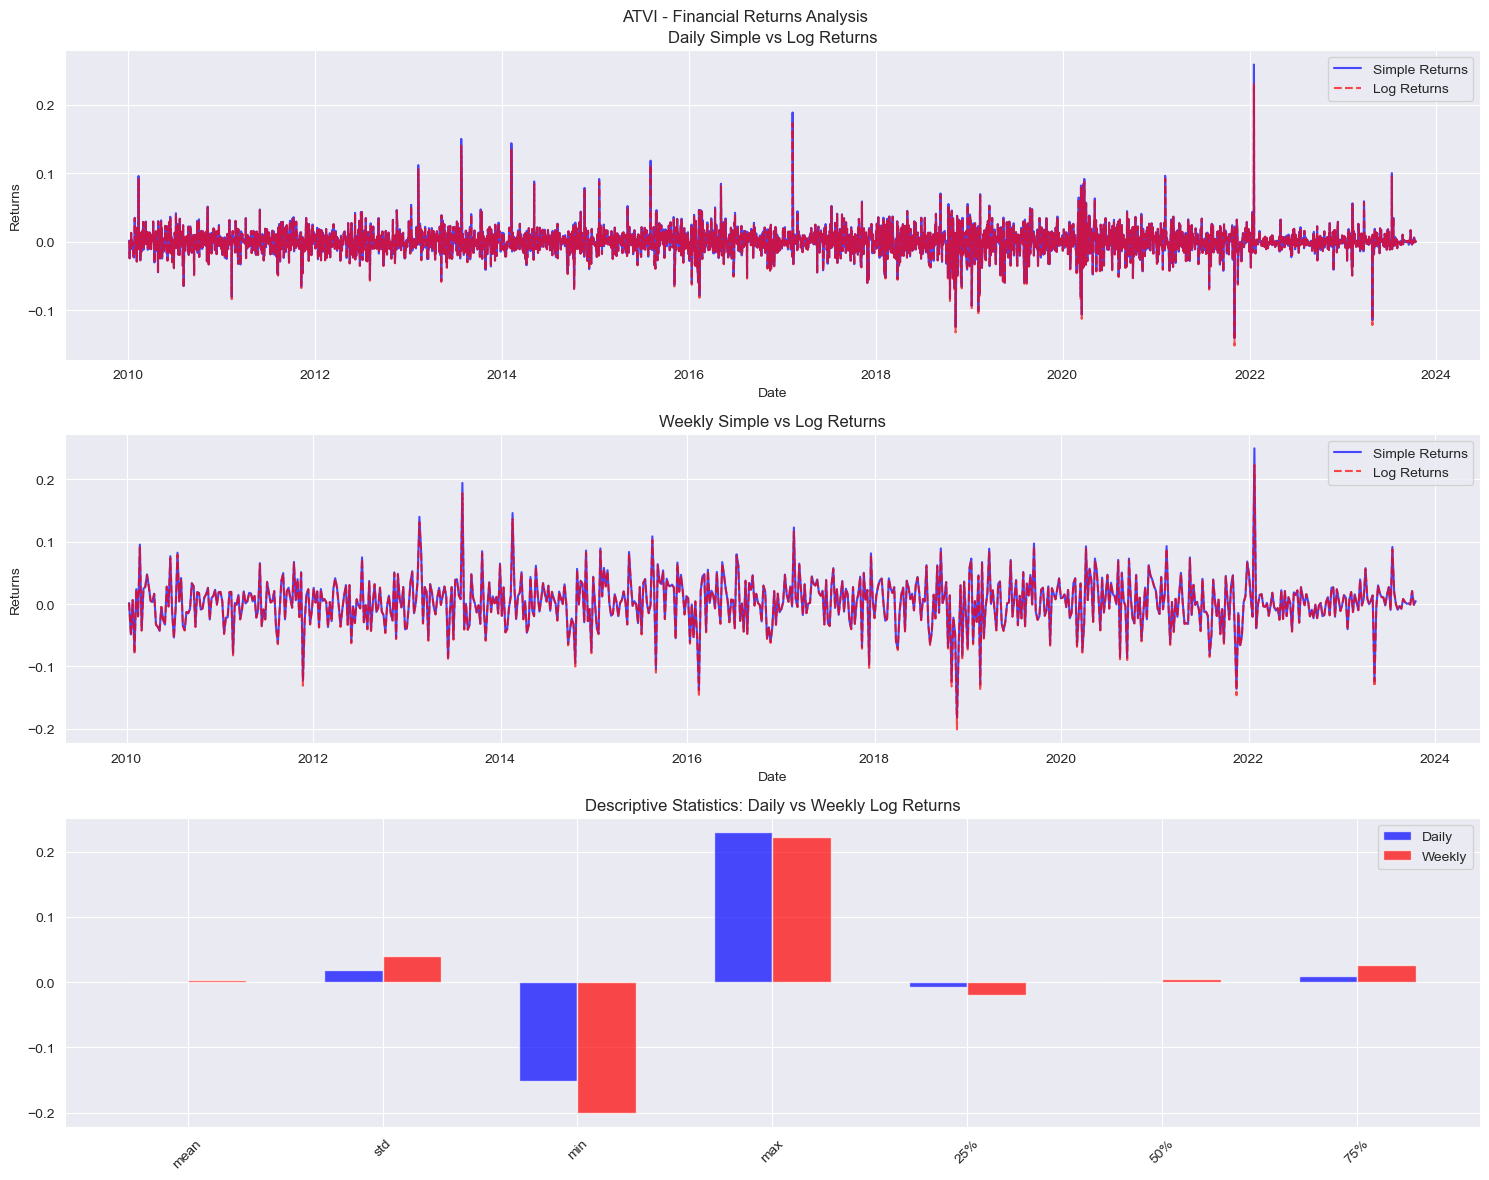

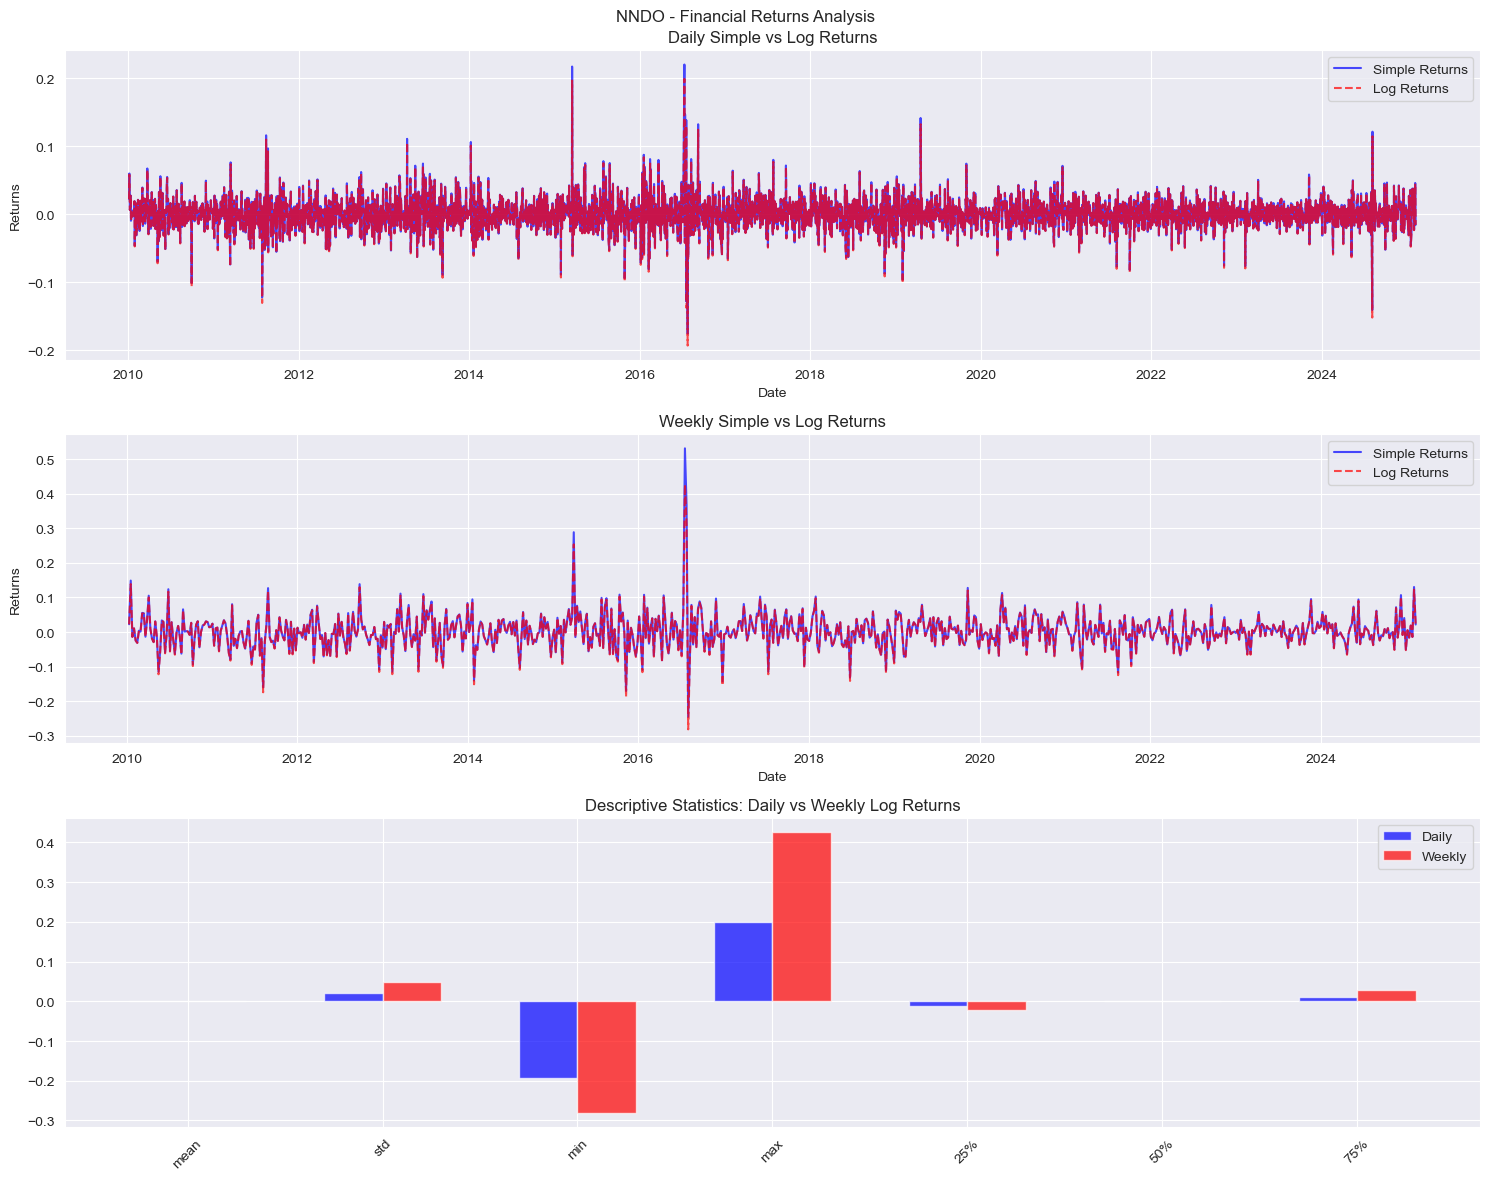

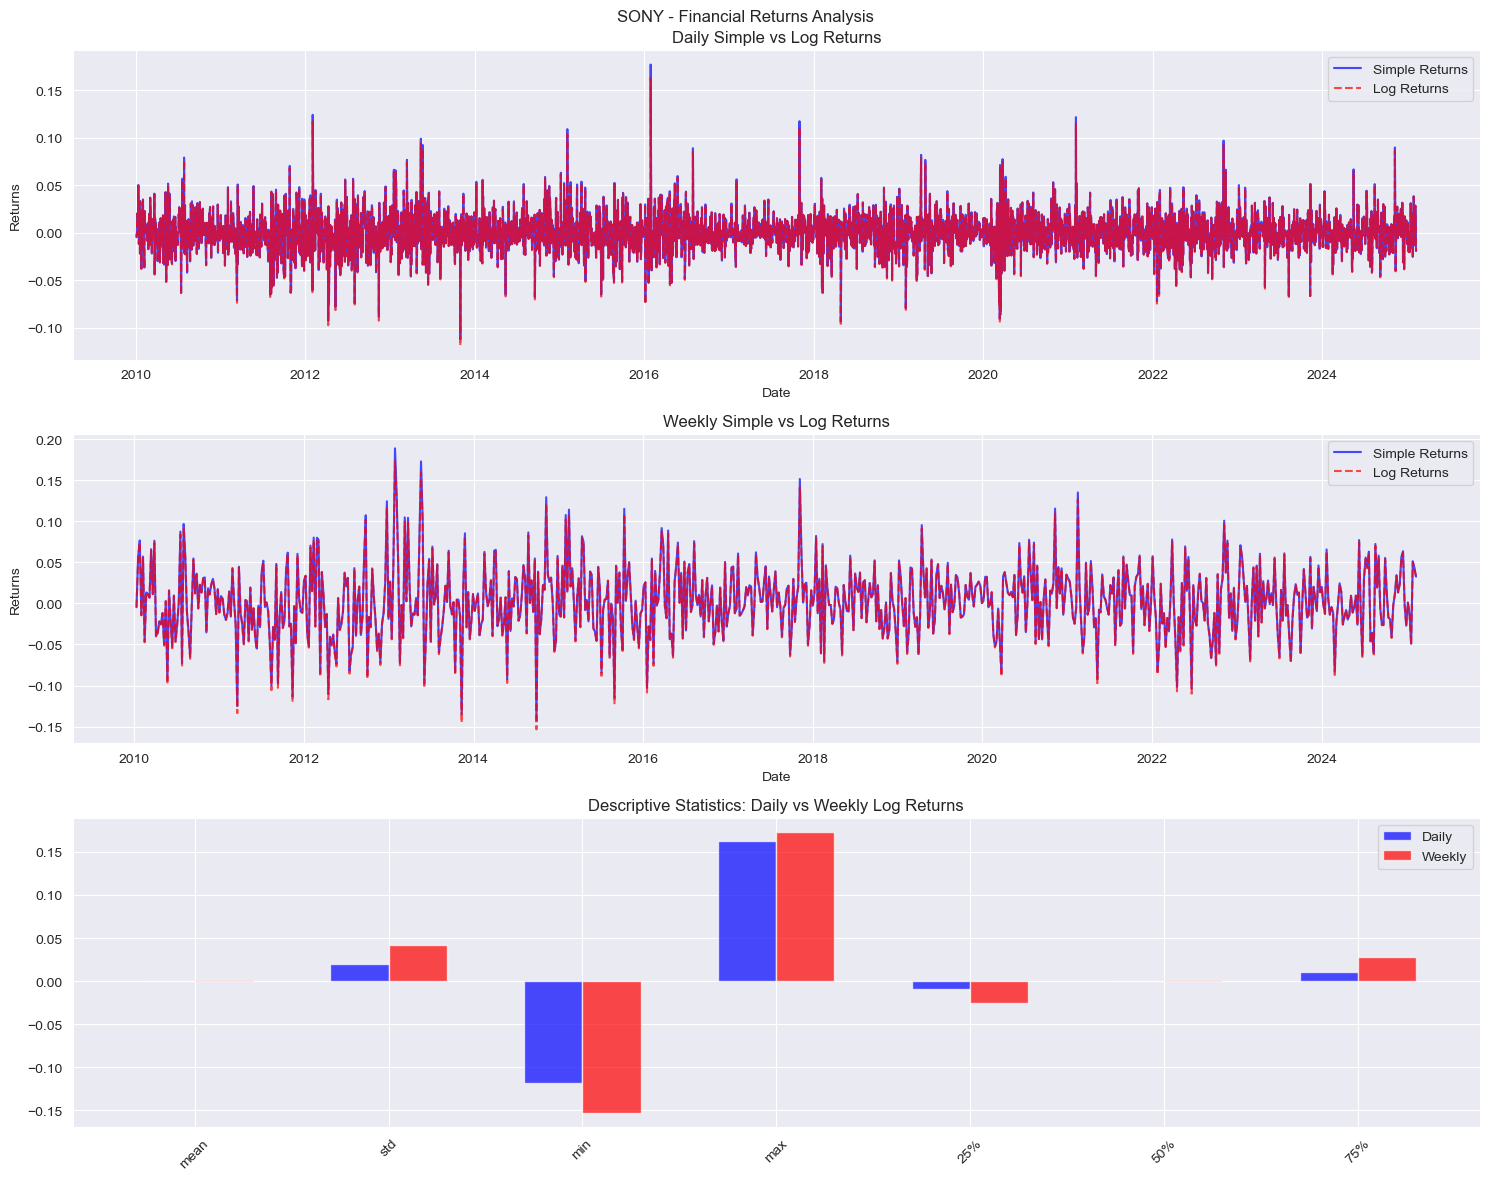

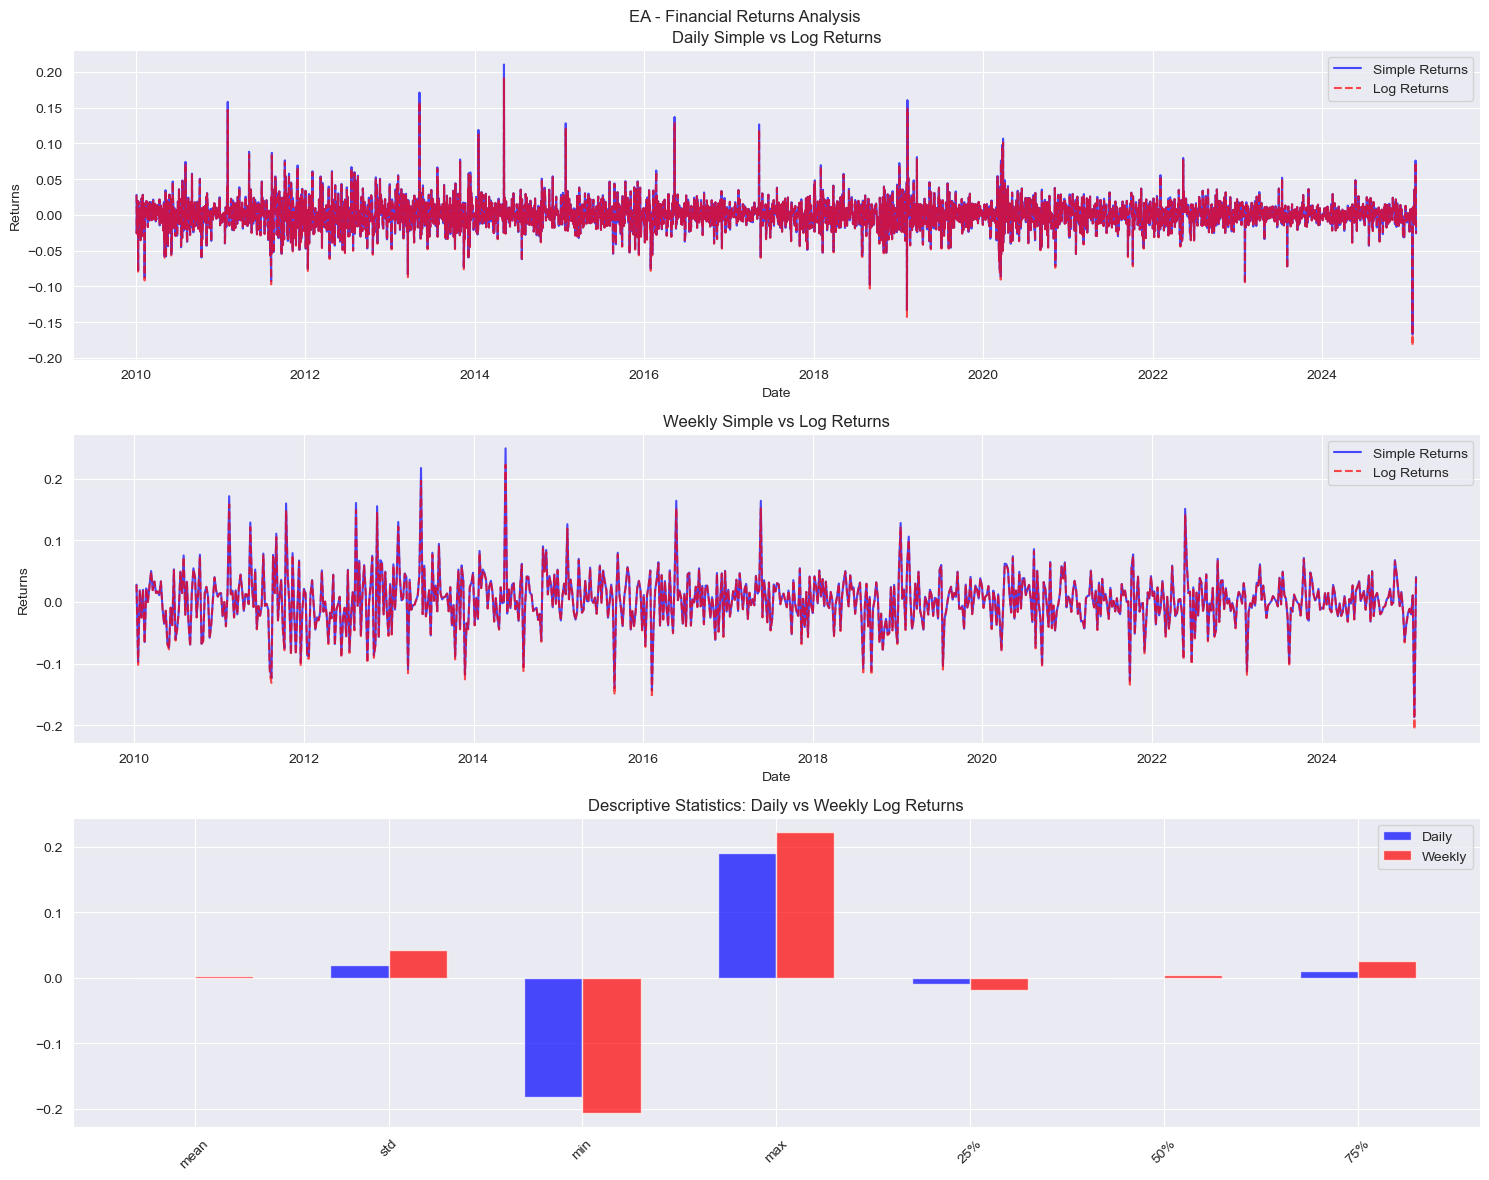

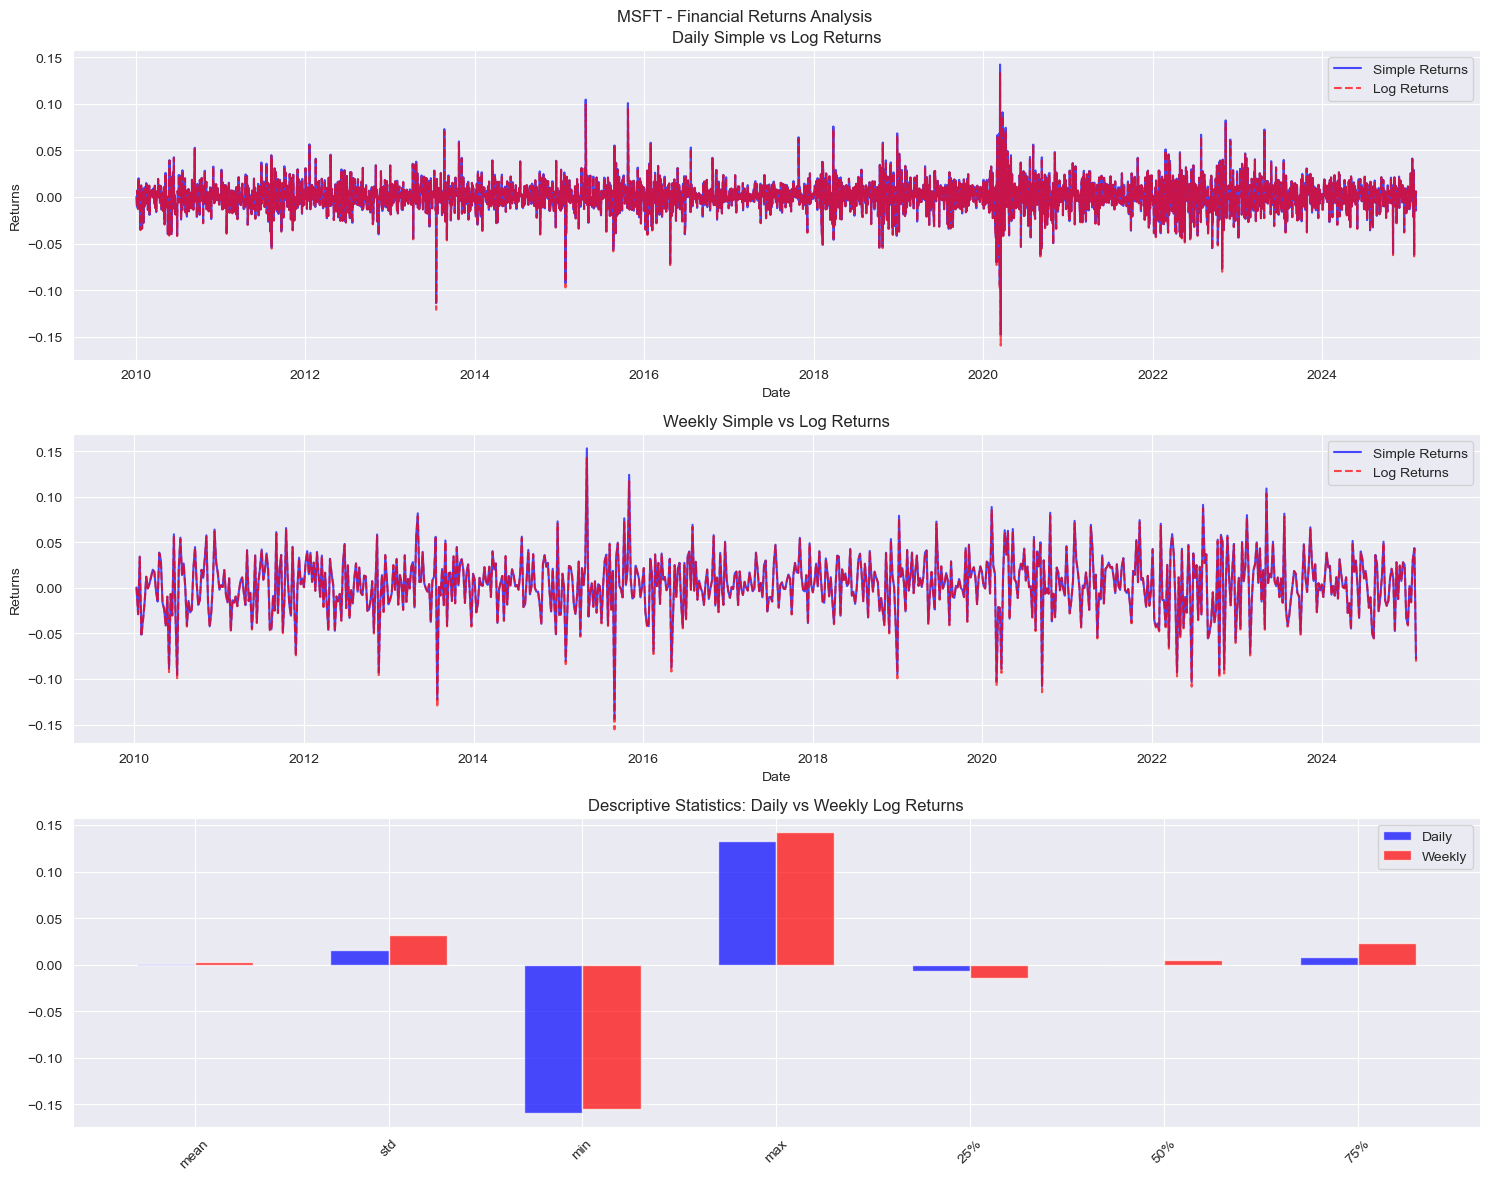

In [4]:
# ---------------------------
# GRAPHS, FOR EACH COMPANY 
#1. Daily Simple vs Log Returns
#2. Weekly Simple vs Log Returns
#3. Descriptive Statistics: Daily vs Weekly Log Returns
# ---------------------------

# Set style for better visualizations
sns.set_style("darkgrid")
plt.figure(figsize=(15, 12))

# Calculate descriptive statistics for daily and weekly returns
daily_stats = pd.DataFrame({company: daily_log[company].describe() for company in daily_log.columns}).T
weekly_stats = pd.DataFrame({company: weekly_log[company].describe() for company in weekly_log.columns}).T

# Create separate figures for each company
for company in daily_simple.columns:
    fig, axes = plt.subplots(nrows=3, figsize=(15, 12))
    fig.suptitle(f'{company} - Financial Returns Analysis')
    
    # Plot 1: Daily Simple vs Log Returns
    ax1 = axes[0]
    ax1.plot(daily_simple.index, daily_simple[company], label='Simple Returns', color='blue', alpha=0.7)
    ax1.plot(daily_log.index, daily_log[company], '--', label='Log Returns', color='red', alpha=0.7)
    ax1.set_title('Daily Simple vs Log Returns')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Returns')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Weekly Simple vs Log Returns
    ax2 = axes[1]
    ax2.plot(weekly_simple.index, weekly_simple[company], label='Simple Returns', color='blue', alpha=0.7)
    ax2.plot(weekly_log.index, weekly_log[company], '--', label='Log Returns', color='red', alpha=0.7)
    ax2.set_title('Weekly Simple vs Log Returns')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Returns')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Descriptive Statistics
    ax3 = axes[2]
    stats_labels = ["mean", "std", "min", "max", "25%", "50%", "75%"]
    x = np.arange(len(stats_labels))
    width = 0.3  # Bar width
    
    ax3.bar(x - width/2, daily_stats.loc[company, stats_labels], width, label='Daily', color='blue', alpha=0.7)
    ax3.bar(x + width/2, weekly_stats.loc[company, stats_labels], width, label='Weekly', color='red', alpha=0.7)
    ax3.set_title('Descriptive Statistics: Daily vs Weekly Log Returns')
    ax3.set_xticks(x)
    ax3.set_xticklabels(stats_labels, rotation=45)
    ax3.legend()
    ax3.grid(True)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()




Log Prices Summary Statistics:
          Mean  Variance  St. Deviation  Skewness  Kurtosis   Minimum  \
ATVI  3.531534  0.593155       0.770166 -0.258466 -1.501881  2.303585   
NNDO  3.288225  0.328609       0.573244 -0.322657 -1.305408  2.197225   
SONY  2.110358  0.443174       0.665713 -0.092137 -1.182476  0.655445   
EA    4.129828  0.693928       0.833023 -0.659359 -1.177834  2.392883   
MSFT  4.478124  0.927266       0.962946  0.235909 -1.422096  3.135929   

       Maximum  
ATVI  4.642562  
NNDO  4.283724  
SONY  3.247191  
EA    5.123785  
MSFT  6.147528  


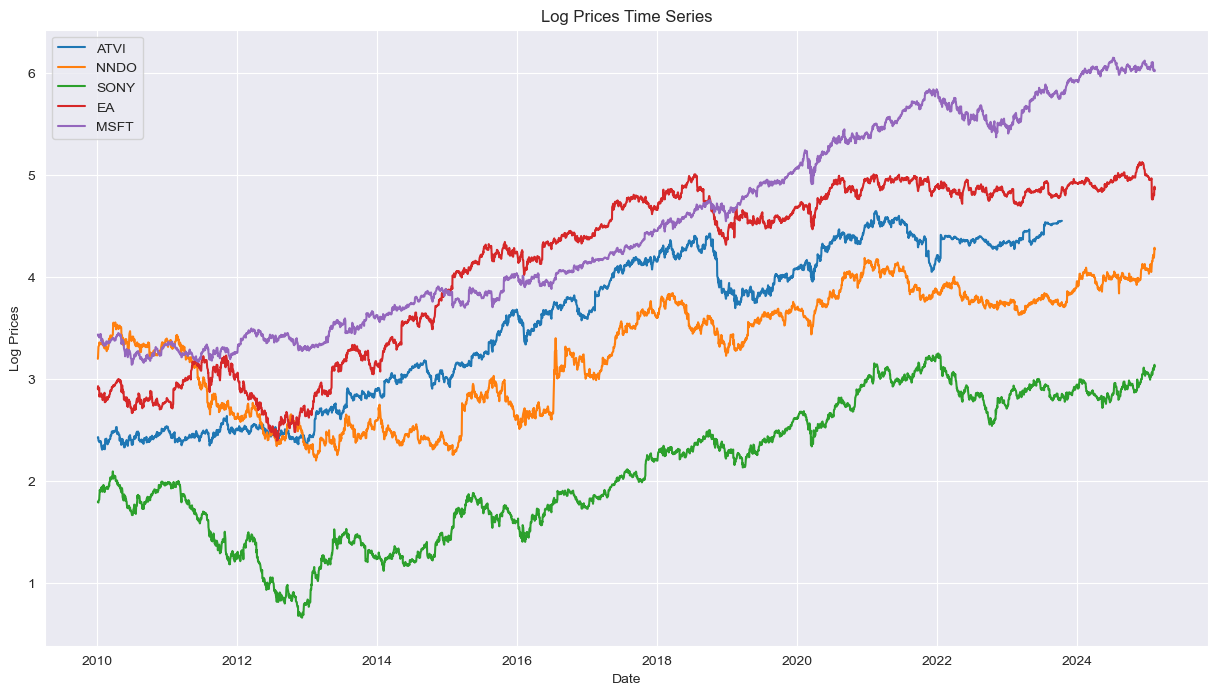

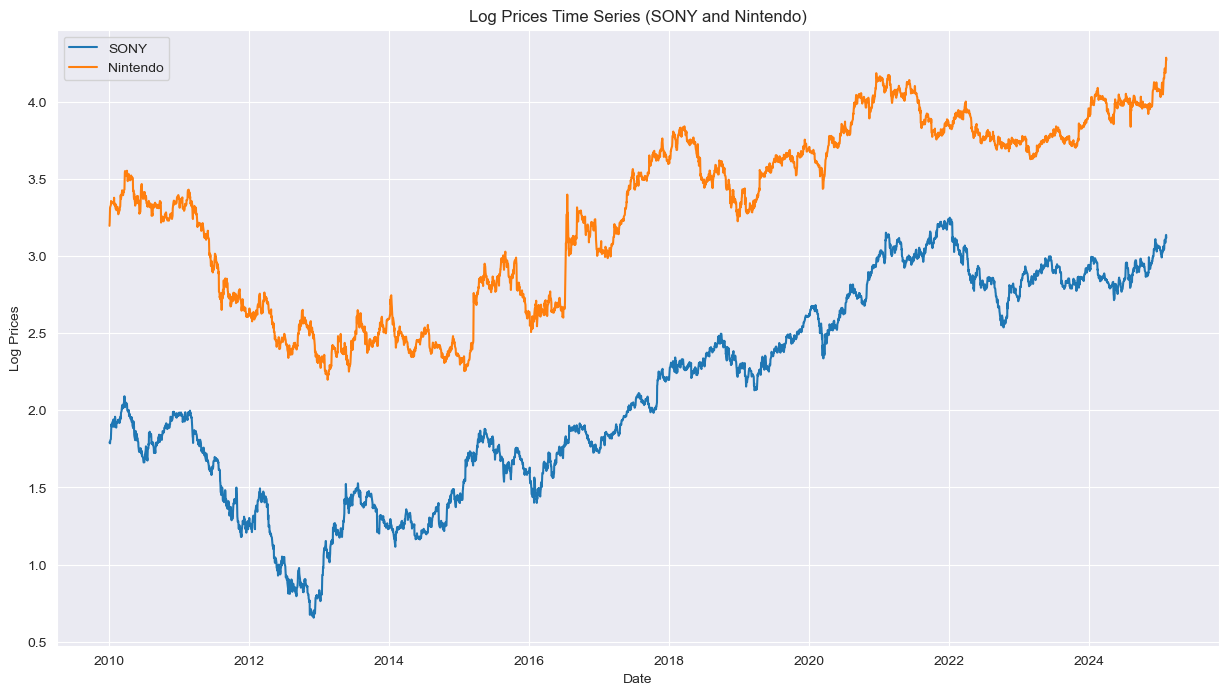

In [5]:
# ---------------------------
# STATIONARITY 
# ---------------------------

# Transform the price series into log prices.
log_prices = np.log(df_entertainment)

def summary_stats_log_prices(prices_df):
    """
    Computes summary statistics for the log prices.
    For each company it computes: Mean, Variance, Skewness, Kurtosis, Minimum, and Maximum.
    """
    # Using pandas describe() and agg() methods for vectorized operations
    summary = pd.DataFrame({
        'Mean': prices_df.mean(),
        'Variance': prices_df.var(),
        'St. Deviation': prices_df.std(),
        'Skewness': prices_df.skew(),
        'Kurtosis': prices_df.kurtosis(),
        'Minimum': prices_df.min(),
        'Maximum': prices_df.max()
    }).T.T  # Double transpose to maintain the same structure as before

    return summary

log_prices_summary = summary_stats_log_prices(log_prices)
print("\nLog Prices Summary Statistics:")
print(log_prices_summary)


# Line Graph of Log Prices Time Series (all companies on one graph)
plt.figure(figsize=(15, 8))
for company in log_prices.columns:
    plt.plot(log_prices.index, log_prices[company], label=company)
plt.title('Log Prices Time Series')
plt.xlabel('Date')
plt.ylabel('Log Prices')
plt.legend()
plt.grid(True)
plt.show()

# print the graph just for sony and nintendo 
plt.figure(figsize=(15, 8))
plt.plot(log_prices.index, log_prices["SONY"], label="SONY")
plt.plot(log_prices.index, log_prices["NNDO"], label="Nintendo")
plt.title('Log Prices Time Series (SONY and Nintendo)')
plt.xlabel('Date')
plt.ylabel('Log Prices')
plt.legend()
plt.grid(True)
plt.show()

 

In [6]:
def perform_adf_test(series, name):
    """
    Perform Augmented Dickey-Fuller (ADF) test on a time series.
    
    Parameters:
    - series (pd.Series): Time series data.
    - name (str): Name of the series for reference.
    
    Returns:
    - str: 'stationary' or 'non-stationary'
    """
    result = adfuller(series.dropna())
    
    # Extract test results
    test_stat, p_value, _, _, critical_values, _ = result
    
    print(f"\nADF Test for {name}:")
    print(f"Test Statistic: {test_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    # Display critical values
    print("Critical Values:", {k: f"{v:.4f}" for k, v in critical_values.items()})

    # Interpretation
    if p_value < 0.05:
        print("Conclusion: The series is stationary (Reject H0)")
        return "stationary"
    else:
        print("Conclusion: The series is non-stationary (Fail to reject H0)")
        return "non-stationary"

# Compute log prices and log returns
log_prices = np.log(df_entertainment)
log_returns = log_prices.diff()

print("\nRunning ADF Stationarity Analysis on Log Prices & Log Returns...\n")

# Perform analysis for each company
results = {
    company: {
        'Log Prices': perform_adf_test(log_prices[company], f"{company} Log Prices"),
        'Log Returns': perform_adf_test(log_returns[company], f"{company} Log Returns")
    }
    for company in log_prices.columns
}

# Display summary results
summary_df = pd.DataFrame(results).T
print("\nStationarity Summary:\n", summary_df)


Running ADF Stationarity Analysis on Log Prices & Log Returns...


ADF Test for ATVI Log Prices:
Test Statistic: -0.9605
p-value: 0.7674
Critical Values: {'1%': '-3.4322', '5%': '-2.8623', '10%': '-2.5672'}
Conclusion: The series is non-stationary (Fail to reject H0)

ADF Test for ATVI Log Returns:
Test Statistic: -15.2174
p-value: 0.0000
Critical Values: {'1%': '-3.4322', '5%': '-2.8623', '10%': '-2.5672'}
Conclusion: The series is stationary (Reject H0)

ADF Test for NNDO Log Prices:
Test Statistic: -0.6611
p-value: 0.8566
Critical Values: {'1%': '-3.4320', '5%': '-2.8623', '10%': '-2.5672'}
Conclusion: The series is non-stationary (Fail to reject H0)

ADF Test for NNDO Log Returns:
Test Statistic: -26.9008
p-value: 0.0000
Critical Values: {'1%': '-3.4320', '5%': '-2.8623', '10%': '-2.5672'}
Conclusion: The series is stationary (Reject H0)

ADF Test for SONY Log Prices:
Test Statistic: -0.3664
p-value: 0.9156
Critical Values: {'1%': '-3.4320', '5%': '-2.8623', '10%': '-2.5672'}
Conc


Empirical Critical Values (T=100, Random Walk):
1%: -3.501
5%: -2.905
10%: -2.599


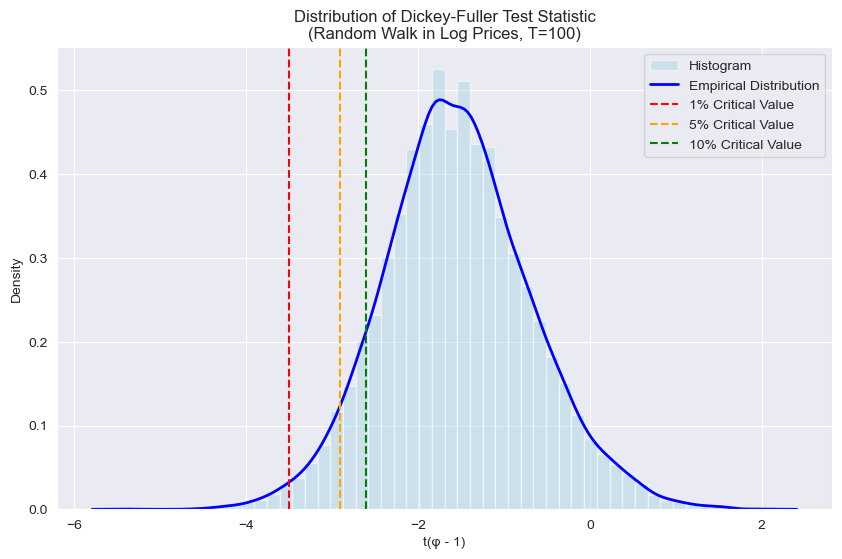


Empirical Critical Values (T=100, AR(1) (phi=0.2)):
1%: -10.362
5%: -9.629
10%: -9.271


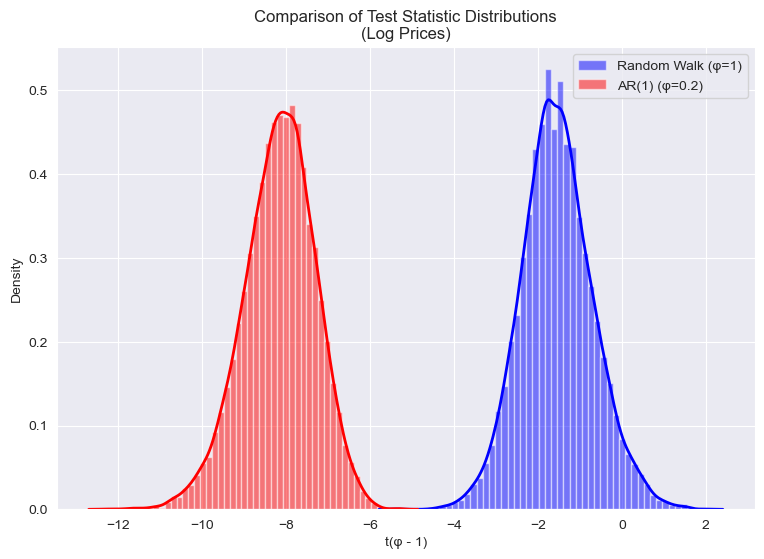

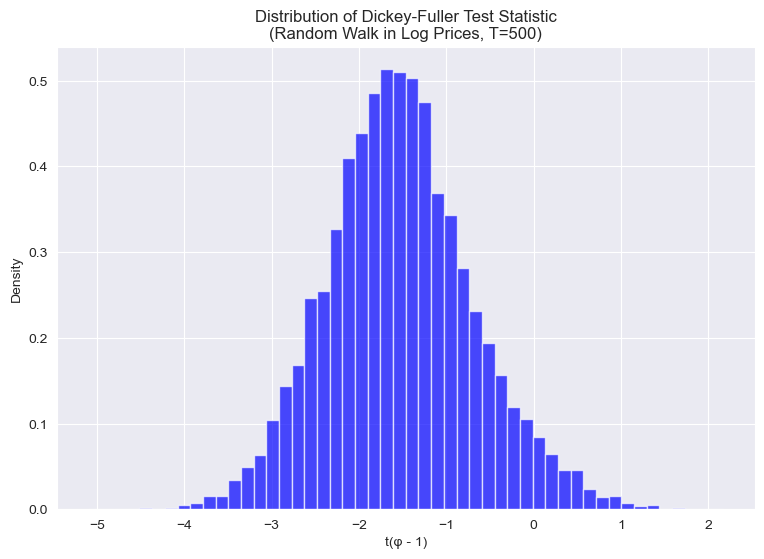


Critical Values (T=500):
1%: -3.401
5%: -2.866
10%: -2.580


In [7]:
def simulate_df_distribution(T, N, phi=1.0):
    """
    Simulate the distribution of the Dickey-Fuller test statistic for log prices.
    
    Parameters:
      T (int): Length of each simulated time series.
      N (int): Number of Monte Carlo replications.
      phi (float): AR(1) coefficient for the log price process.
                 Use phi=1.0 for a random walk (unit root).
    
    Returns:
      numpy.ndarray: Array of N Dickey-Fuller test statistics computed as t(φ̂ - 1).
    """
    test_stats = np.zeros(N)

    for i in range(N):
        # 1. Simulate error terms εt ~ N(0, 1)
        errors = np.random.normal(0, 1, T)

        # 2. Generate the log price series: 
        #    For phi=1, use a random walk; otherwise simulate an AR(1) process.
        if phi == 1:
            log_prices_sim = np.cumsum(errors)
        else:
            log_prices_sim = np.zeros(T)
            log_prices_sim[0] = errors[0]
            for t in range(1, T):
                log_prices_sim[t] = phi * log_prices_sim[t-1] + errors[t]
        
        # 3. Prepare data for the AR(1) regression: p_t = μ + φ * p_(t-1) + εt
        #    Use observations t = 2,...,T (dropping the very first to reduce initialization effects)
        X = sm.add_constant(log_prices_sim[:-1])
        y = log_prices_sim[1:]
        X, y = X[1:], y[1:]
        model = sm.OLS(y, X).fit()
        
        # 4. Compute the test statistic: t(φ̂ - 1)
        phi_hat = model.params[1]
        se_phi = model.bse[1]
        test_stats[i] = (phi_hat - 1) / se_phi
    
    return test_stats

# Set parameters for the Monte Carlo simulation
N_mc = 10000  # Number of replications
T_mc = 100    # Length of each simulated series

# -- Random Walk Simulation (phi = 1) --
test_stats_rw = simulate_df_distribution(T_mc, N_mc, phi=1.0)

# Compute empirical critical values (percentiles)
critical_values = np.percentile(test_stats_rw, [1, 5, 10])
print("\nEmpirical Critical Values (T=100, Random Walk):")
print(f"1%: {critical_values[0]:.3f}")
print(f"5%: {critical_values[1]:.3f}")
print(f"10%: {critical_values[2]:.3f}")

plt.figure(figsize=(10, 6))
# Plot histogram
plt.hist(test_stats_rw, bins=50, density=True, alpha=0.5, color="lightblue", label="Histogram")
# Overlay the KDE plot
sns.kdeplot(test_stats_rw, label="Empirical Distribution", color="blue", lw=2)
plt.axvline(critical_values[0], color="red", linestyle="--", label="1% Critical Value")
plt.axvline(critical_values[1], color="orange", linestyle="--", label="5% Critical Value")
plt.axvline(critical_values[2], color="green", linestyle="--", label="10% Critical Value")
plt.title('Distribution of Dickey-Fuller Test Statistic\n(Random Walk in Log Prices, T=100)')
plt.xlabel('t(φ - 1)')
plt.ylabel('Density')
plt.legend()
plt.show()


# -- Stationary AR(1) Simulation (phi = 0.2) --
test_stats_ar = simulate_df_distribution(T_mc, N_mc, phi=0.2)

# CI FOR THIS ONE MAYBE BETTERE TO ELIMINATE !!!!!!  NOT USEFUL !!!!!!!
# Compute empirical critical values (percentiles)
critical_values_ar = np.percentile(test_stats_ar, [1, 5, 10])
print("\nEmpirical Critical Values (T=100, AR(1) (phi=0.2)):")
print(f"1%: {critical_values_ar[0]:.3f}")
print(f"5%: {critical_values_ar[1]:.3f}")
print(f"10%: {critical_values_ar[2]:.3f}")

# Compare the distributions (Random Walk vs. AR(1) with phi=0.2)
plt.figure(figsize=(9, 6))
# Plot histograms for both distributions
plt.hist(test_stats_rw, bins=50, density=True, alpha=0.5, color='blue', label='Random Walk (φ=1)')
plt.hist(test_stats_ar, bins=50, density=True, alpha=0.5, color='red', label='AR(1) (φ=0.2)')
# Add KDE overlays using seaborn
sns.kdeplot(test_stats_rw, color='blue', lw=2)
sns.kdeplot(test_stats_ar, color='red', lw=2)
plt.title('Comparison of Test Statistic Distributions\n(Log Prices)')
plt.xlabel('t(φ - 1)')
plt.ylabel('Density')
plt.legend()
plt.show()


# -- Simulate for T=500 , as we will need the corresponding critical values later in the project --
T_500 = 500
test_stats_rw_500 = simulate_df_distribution(T_500, N_mc, phi=1.0)

# Plot histogram for T=500
plt.figure(figsize=(9, 6))
plt.hist(test_stats_rw_500, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Distribution of Dickey-Fuller Test Statistic\n(Random Walk in Log Prices, T=500)')
plt.xlabel('t(φ - 1)')
plt.ylabel('Density')
plt.show()

# Compute critical values for T=500
critical_values_500 = np.percentile(test_stats_rw_500, [1, 5, 10])
print("\nCritical Values (T=500):")
print(f"1%: {critical_values_500[0]:.3f}")
print(f"5%: {critical_values_500[1]:.3f}")
print(f"10%: {critical_values_500[2]:.3f}")

In [9]:
# ---------------------------
# 2.2 TESTING NON STATIONARITY
# ---------------------------


#---------------------------
# For this point the previus code alreay contains what we need
# chat for example suggests in this part to add a cosntant to the AR(1) process

#------------------------------------------------------
# def perform_adf_test(series, name):
    # """
    # Perform Augmented Dickey-Fuller (ADF) test on a time series.
    
    # Parameters:
    # - series (pd.Series): Time series data.
    # - name (str): Name of the series for reference.
    
    # Returns:
    # - str: 'stationary' or 'non-stationary'
    # """
    # result = adfuller(series.dropna(), regression='c')
#------------------------------------------------------


# these should be the three possibilities for the regression parameter

		# Version 2: ADF Test with Different Model Specifications

		# 1)No constant, no trend ('nc') → Used for pure random walks.
		# 2)Constant ('c') → Used when data has a mean but no trend.
		# 3)Constant & trend ('ct') → Used when data has a deterministic trend.



In [8]:
stationarity_results_ADF = []
stationarity_results_DF = []
stationarity_results_DF_MC = []

for company in log_prices.columns:
    series = log_prices[company].dropna()
    print(f"\n----- Analysis for {company} -----\n")
    
    # 1. AR(1) Regression: p_t = µ + ϕ p_(t-1) + ε_t
    df_reg = pd.DataFrame({"p": series})
    df_reg["p_lag"] = df_reg["p"].shift(1)
    df_reg = df_reg.dropna()
    X = sm.add_constant(df_reg["p_lag"])
    y = df_reg["p"]
    
    model = sm.OLS(y, X).fit()
    print("\nAR(1) Regression Results:")
    print(model.summary())
    
    # 2. Breusch–Godfrey (Godfrey) test for autocorrelation in regression residuals
    bg_test = acorr_breusch_godfrey(model, nlags=5)
    print(f"Breusch-Godfrey test for {company}: LM stat={bg_test[0]:.4f}, p-value={bg_test[1]:.4f}")
    
    # 3. White's test for heteroskedasticity
    white_test = het_white(model.resid, X)
    print(f"White's heteroskedasticity test for {company}: LM stat={white_test[0]:.4f}, p-value={white_test[1]:.4f}")
    
    # 2 and 3 done to show how residuals do not satisfy OLS assumption and hint to non-stationarity.
    
    # 4. Dickey-Fuller test for stationarity on the log-price series
    
    # ADF with constant + trend (ct): 
    # 1) augmentation to avoid autocorrelated residuals (violation of OLS assumption)
    # => invalid test size, biased inference, underestimates persistence.
    # 2) trend because log-prices seam to exhibit a deterministic upward trend in our sample
    # => testing without a trend would bias the test toward non-rejection of the unit root.
    adf_result = adfuller(series.dropna(), regression='ct', autolag='AIC')
    print(f"\nAugmented Dickey-Fuller test for {company}:")
    print(f"Test Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
    critical_values = adf_result[4]
    print("Critical Values (MacKinnon (2010)):", {k: f"{v:.4f}" for k, v in critical_values.items()})
    p_value = adf_result[1]
    # Interpretation
    if p_value < 0.05:
        print("Conclusion: The series is stationary (Reject H0)")
        status = 'Stationary'
    else:
        print("Conclusion: The series is non-stationary (Fail to reject H0)")
        status = 'Non-stationary'
    
    stationarity_results_ADF.append({
        'Company': company,
        'ADF Test Statistic': round(adf_result[0], 4),
        'ADF p-value': round(p_value, 4),
        'Stationarity': status
    })

    # DF with constant (c): 
    # exact reparametrization requested by the assignment.
    # probably biased inference
    df_result = adfuller(series.dropna(), maxlag=0, regression='c')  # constant, no trend
    print(f"\nDickey-Fuller test for {company}:")
    print(f"Test Statistic: {df_result[0]:.4f}, p-value: {df_result[1]:.4f}")
    critical_values = df_result[4]
    print("Critical Values (MacKinnon (2010)):", {k: f"{v:.4f}" for k, v in critical_values.items()})
    p_value = df_result[1]
    # Interpretation
    if p_value < 0.05:
        print("Conclusion: The series is stationary (Reject H0)")
        status = 'Stationary'
    else:
        print("Conclusion: The series is non-stationary (Fail to reject H0)")
        status = 'Non-stationary'
    
    stationarity_results_DF.append({
        'Company': company,
        'DF Test Statistic': round(df_result[0], 4),
        'DF p-value': round(p_value, 4),
        'Stationarity': status
    })
    
    # either way both ADF and DF always fail to reject the H_0 of unit root for all stocks
    
    # 7. Regression for Log Returns (t-stat of p_lag is t-stat for DF):
    #    r_t = p_t - p_(t-1) = Δp_t = μ + ϕ p_(t-1) + ε_t, with p_t = log(P_t)
    df_reg_return = pd.DataFrame({"p": series})
    df_reg_return["r"] = df_reg_return["p"] - df_reg_return["p"].shift(1)
    df_reg_return["p_lag"] = df_reg_return["p"].shift(1)
    df_reg_return = df_reg_return.dropna()
    X_return = sm.add_constant(df_reg_return["p_lag"])
    y_return = df_reg_return["r"]
    model_return = sm.OLS(y_return, X_return).fit()
    
    print("\nAdditional Regression: r_t = μ + ϕ p_(t-1) + ε_t, with r_t = p_t - p_(t-1)")
    print(model_return.summary())
    
    #p_value_empirical = compute_empirical_p_value_one_tailed(model_return.tvalues["p_lag"], test_stats_rw)
    # maybe the following allows us to eliminate the function compute_empirical_p_value_one_tailed !!!!!
    
    # compute empirical one-tailed p-value based on simulated distribution
    p_value_empirical = np.mean(test_stats_rw <= model_return.tvalues["p_lag"])
    
    
    stationarity_results_DF_MC.append({
    'Company': company,
    'DF Test Statistic': model_return.tvalues["p_lag"],
    'DF p-value': p_value_empirical,
    'Stationarity': 'Stationary' if p_value_empirical < 0.05 else 'Non-stationary'
    })


stationarity_results_ADF = pd.DataFrame(stationarity_results_ADF)
print("=== Augmented Dickey-Fuller (ADF) Test Results ===")
print("The ADF test is augmented. It has a constant and a trend. This augmentation helps to account for autocorrelation in the error term and a deterministic trend in the data. The null hypothesis is that the series has a unit root (non-stationary) against the alternative that it is stationary around a trend. Critical values based on MacKinnon (2010).\n")
print(stationarity_results_ADF)
print("\n")

stationarity_results_DF = pd.DataFrame(stationarity_results_DF)
print("=== Dickey-Fuller (DF) Test Results ===")
print("The DF test here is performed without augmentation. A constant is included and no trend is added. This simpler specification might lead to biased inference in the presence of autocorrelation. Critical values based on MacKinnon (2010)\n")
print(stationarity_results_DF)
print("\n")

stationarity_results_DF_MC = pd.DataFrame(stationarity_results_DF_MC)
print("=== Monte Carlo-based DF (DF_MC) Test Results ===")
print("The DF_MC test also uses a regression with only a constant (no trend), like the DF test. However, its p-values are derived using a Monte Carlo simulation of the t-statistic t(ϕ - 1) under the null hypothesis (unit root). This simulation provides an empirical distribution for the test statistic, which can yield more accurate inference in finite samples.\n")
print(stationarity_results_DF_MC)


----- Analysis for ATVI -----


AR(1) Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 6.020e+06
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:35:10   Log-Likelihood:                 9180.0
No. Observations:                3593   AIC:                        -1.836e+04
Df Residuals:                    3591   BIC:                        -1.834e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [9]:
###############################################################################
# PART 3: "Cointegration"
# We test for cointegration for all the possible pairs in our dataset.
###############################################################################

def cointegration_df_statistic(residuals):
    """
    Given the residuals z_t from a cointegration regression,
    compute the Dickey-Fuller test statistic by estimating:
       Δz_t = μ + φ·z_{t-1} + ε_t.
    Returns the t-statistic for the coefficient φ.
    """
    # Convert to numpy array if residuals is a pandas Series.
    z = residuals.values if hasattr(residuals, "values") else residuals
    # Compute differences: Δz_t = z_t - z_{t-1}
    dz = np.diff(z)
    # Use z_{t-1} as the lagged residual (matching the length of dz)
    z_lag = z[:-1]
    X = sm.add_constant(z_lag)
    model = sm.OLS(dz, X).fit()
    t_stat = model.tvalues[1]  # t-value for the coefficient on z_lag
    return t_stat


def simulate_cointegration_df_distribution(T, N, seed=None):
    """
    Simulate the distribution of the Dickey-Fuller test statistic for cointegration testing.
    
    Procedure:
      1. Simulate two independent random walks p_A and p_B of length T.
      2. Estimate the cointegration regression: p_A = α + β·p_B + z.
      3. Compute the DF test statistic on the residuals z by regressing:
             Δz_t = μ + φ·z_{t-1} + ε_t
         and obtaining the t-statistic for φ.
      4. Repeat N times.
    
    Returns:
      A numpy array of N simulated t-statistics.
    """
    if seed is not None:
        np.random.seed(seed)
    t_stats = np.zeros(N)
    for i in range(N):
        # Simulate independent random walks
        errors_A = np.random.normal(0, 1, T)
        errors_B = np.random.normal(0, 1, T)
        p_A = np.cumsum(errors_A)
        p_B = np.cumsum(errors_B)
        # Estimate cointegration regression: p_A = α + β·p_B + z
        X_sim = sm.add_constant(p_B)
        model_sim = sm.OLS(p_A, X_sim).fit()
        z_sim = model_sim.resid
        # Compute the DF test statistic on the simulated residuals
        t_stats[i] = cointegration_df_statistic(z_sim)
    return t_stats

# -- Simulate for T=500 , as we will need the corresponding critical values later in the project --
T_sim = 500
N_sim=10000
test_stats_rw_500_cointegration =  simulate_cointegration_df_distribution(T_sim, N_sim, seed=42)
# Compute critical values for T=500
critical_values_500_cointegration = np.percentile(test_stats_rw_500_cointegration, [10, 5, 1])
print(f"DF Critical Values for T = {T_sim}:")
print(f"1%: {critical_values_500_cointegration[2]:.3f}")
print(f"5%: {critical_values_500_cointegration[1]:.3f}")
print(f"10%: {critical_values_500_cointegration[0]:.3f}")
# ------------------------------------------------------------------------------------------------

# -- Simulate for T=100 
T_sim = 100
test_stats_rw_100_cointegration = simulate_cointegration_df_distribution(T_sim, N_sim, seed=42)
# Compute empirical critical values fot T=100
critical_values_100_cointegration = np.percentile(test_stats_rw_100_cointegration, [10, 5, 1])
print(f"DF Critical Values for T = {T_sim}:")
print(f"1%: {critical_values_100_cointegration[2]:.3f}")
print(f"5%: {critical_values_100_cointegration[1]:.3f}")
print(f"10%: {critical_values_100_cointegration[0]:.3f}")
#------------------------------------------------------------------------------------------------

def test_cointegration(price_y, price_x, N_sim=10000):
    """
    Test for cointegration between two price series using the Engle-Granger method,
    following the procedure in Section 3.1 of the assignment.
    
    Procedure:
      1. Estimate the cointegration regression:
             price_y = α + β·price_x + z
         and compute the residuals z.
      2. Compute the Dickey-Fuller test statistic on z by estimating:
             Δz_t = μ + φ·z_{t-1} + ε_t
         (this is our DF statistic for cointegration).
      3. Simulate the distribution of t(φ) under the null of no cointegration by
         generating two independent random walks of length T (T = sample size) and
         repeating the cointegration DF procedure N_sim times.
      4. Compute an empirical one-tailed p-value: the proportion of simulated t-statistics
         that are less than or equal to the observed DF statistic.
    
    Returns a dictionary with:
      - 'dependent': name of dependent series
      - 'independent': name of independent series
      - 'test_statistic': the DF test statistic from the residual regression
      - 'p_value': empirical one-tailed p-value based on the simulated distribution
      - 'beta': estimated β from the cointegration regression
      - 'alpha': estimated α from the cointegration regression
      - 'residuals': residual series from the cointegration regression
      - 'cointegrated': True if p_value < 0.05, otherwise False.
    """
    name_y = price_y.name
    name_x = price_x.name

    df = pd.concat([price_y, price_x], axis=1).dropna()
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1])
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    # Compute the cointegration DF statistic on the residuals.
    df_stat = cointegration_df_statistic(residuals)
    
    # Define sample size for simulation T_mc = 100 !
    T_sim = T_mc 
    
    simulated_stats = simulate_cointegration_df_distribution(T_sim, N_sim)
    
    # Compute the one-tailed empirical p-value:
    # Under the null, lower (more negative) values indicate evidence against no cointegration.
    empirical_p_value = np.mean(simulated_stats <= df_stat)
    
    return {
        'dependent': name_y,
        'independent': name_x,
        'test_statistic': df_stat,
        'p_value': empirical_p_value,
        'beta': model.params.iloc[1],
        'alpha': model.params.iloc[0],
        'residuals': residuals,
        'cointegrated': empirical_p_value < 0.05
    }


### using function adfuller instead of Monte-Carlo Simulation fot DF test ###
def test_cointegration_adfuller(price_y, price_x):
    """
    Test for cointegration between two price series using Engle-Granger method.
    price_y is the dependent variable, price_x is the independent variable.
    """
    name_y = price_y.name
    name_x = price_x.name

    df = pd.concat([price_y, price_x], axis=1).dropna()

    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1])
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    #adf_result = adfuller(residuals)
    adf_result = adfuller(residuals, maxlag=0, regression='c')

    return {
        'dependent': name_y,
        'independent': name_x,
        'test_statistic': adf_result[0],
        'p_value': adf_result[1],
        'beta': model.params.iloc[1],
        'alpha': model.params.iloc[0],
        'residuals': residuals,
        'cointegrated': adf_result[1] < 0.05
    }

##########################################################################
# CONTINUAZIONE SOTTO 
##########################################################################

DF Critical Values for T = 500:
1%: -3.973
5%: -3.369
10%: -3.080
DF Critical Values for T = 100:
1%: -3.985
5%: -3.357
10%: -3.069


=== Cointegration Test Results for Each Pair ===

Dependent: ATVI, Independent: NNDO
  Test Statistic: -2.3174
  p-value: 0.3516
  Alpha (αˆ): 0.1166
  Beta  (βˆ): 1.0598
  Cointegrated: No
--------------------------------------------------
Dependent: ATVI, Independent: SONY
  Test Statistic: -2.3051
  p-value: 0.3683
  Alpha (αˆ): 1.4921
  Beta  (βˆ): 1.0027
  Cointegrated: No
--------------------------------------------------
Dependent: ATVI, Independent: EA
  Test Statistic: -3.0439
  p-value: 0.1078
  Alpha (αˆ): -0.1326
  Beta  (βˆ): 0.9043
  Cointegrated: No
--------------------------------------------------
Dependent: ATVI, Independent: MSFT
  Test Statistic: -2.0452
  p-value: 0.5030
  Alpha (αˆ): 0.0009
  Beta  (βˆ): 0.8154
  Cointegrated: No
--------------------------------------------------
Dependent: NNDO, Independent: ATVI
  Test Statistic: -2.3358
  p-value: 0.3586
  Alpha (αˆ): 1.2688
  Beta  (βˆ): 0.5531
  Cointegrated: No
-----------------------------------------------

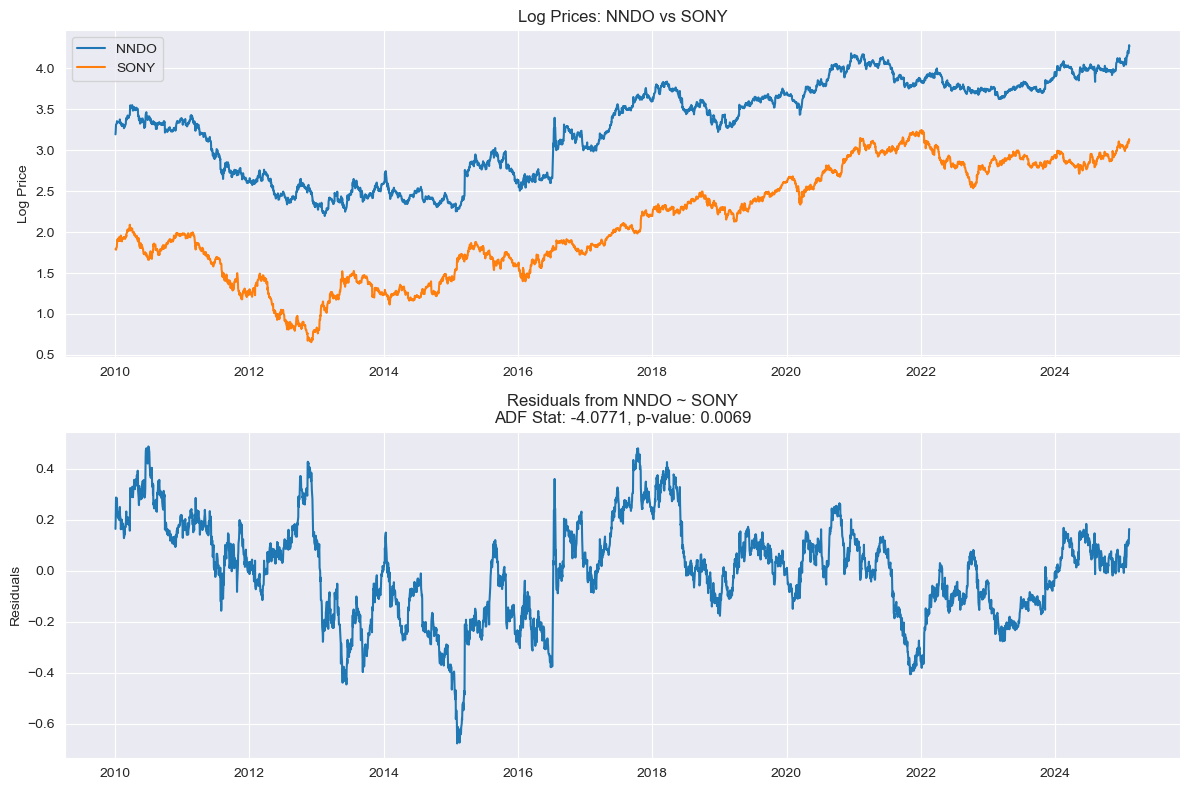


Plotting residuals for pair: SONY ~ NNDO


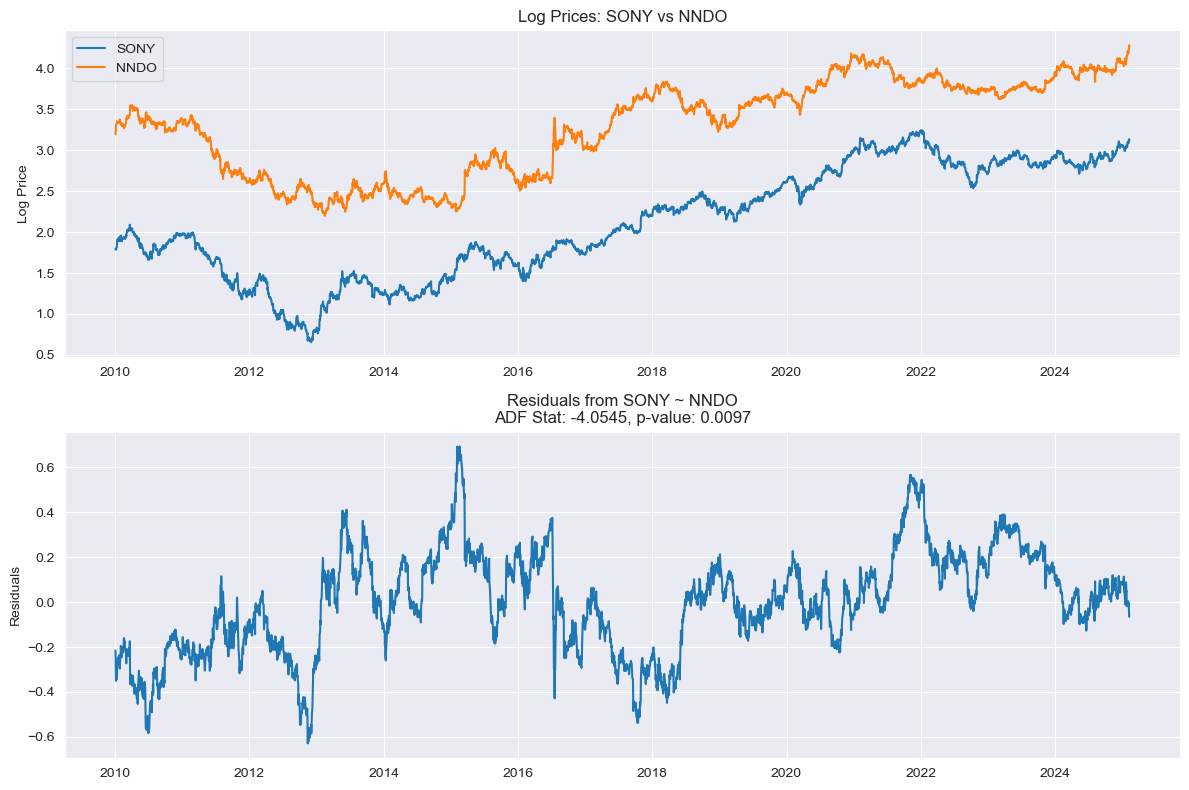

In [10]:
def find_all_ordered_cointegrated_pairs(log_prices_df, p_value_threshold=0.05):
    """
    Test cointegration for all 20 ordered pairs (5 stocks).
    """
    results = []
    for stock_a, stock_b in permutations(log_prices_df.columns, 2):
        result = test_cointegration(log_prices_df[stock_a], log_prices_df[stock_b])
        #result = test_cointegration_adfuller(log_prices_df[stock_a], log_prices_df[stock_b]) # if want to use process with adfuller instead of monte carlo
        results.append(result)
    return pd.DataFrame(results)

def plot_cointegration_residuals(result):
    """
    Plot residuals and log prices from a cointegration regression result.
    """
    y_name = result['dependent']
    x_name = result['independent']
    residuals = result['residuals']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Log prices
    ax1.plot(log_prices[y_name], label=y_name)
    ax1.plot(log_prices[x_name], label=x_name)
    ax1.set_title(f'Log Prices: {y_name} vs {x_name}')
    ax1.set_ylabel("Log Price")
    ax1.legend()

    # Residuals
    ax2.plot(residuals)
    ax2.set_title(f'Residuals from {y_name} ~ {x_name}\nADF Stat: {result["test_statistic"]:.4f}, p-value: {result["p_value"]:.4f}')
    ax2.set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

def analyze_cointegration(log_prices_df):
    """
    Analyze and plot cointegration between all ordered pairs.
    """
    results_df = find_all_ordered_cointegrated_pairs(log_prices_df)

    # Print detailed results for each pair
    print("=== Cointegration Test Results for Each Pair ===\n")
    for idx, row in results_df.iterrows():
        print(f"Dependent: {row['dependent']}, Independent: {row['independent']}")
        print(f"  Test Statistic: {row['test_statistic']:.4f}")
        print(f"  p-value: {row['p_value']:.4f}")
        print(f"  Alpha (αˆ): {row['alpha']:.4f}")
        print(f"  Beta  (βˆ): {row['beta']:.4f}")
        print(f"  Cointegrated: {'Yes' if row['cointegrated'] else 'No'}")
        print("-" * 50)
    
    # Report summary table (subset of key columns)
    print("\n=== Summary Table ===")
    summary_cols = ['dependent', 'independent', 'test_statistic', 'p_value', 'alpha', 'beta', 'cointegrated']
    summary_df = results_df[summary_cols].copy()
    print(summary_df)
    
    # Identify cointegrated pairs
    cointegrated_pairs = results_df[results_df['cointegrated']]
    if not cointegrated_pairs.empty:
        # Most strongly cointegrated: choose the one with the lowest p-value
        strongest = cointegrated_pairs.loc[cointegrated_pairs['p_value'].idxmin()]
        print("\n=== Most Strongly Cointegrated Pair ===")
        print(f"Dependent: {strongest['dependent']}, Independent: {strongest['independent']}")
        print(f"  Test Statistic: {strongest['test_statistic']:.4f}")
        print(f"  p-value: {strongest['p_value']:.4f}")
        print(f"  Alpha (αˆ): {strongest['alpha']:.4f}")
        print(f"  Beta  (βˆ): {strongest['beta']:.4f}")
    else:
        print("\nNo cointegrated pairs were found at the 5% significance level.")
        
        

    # Plot residuals for each cointegrated pair
    for _, row in cointegrated_pairs.iterrows():
        print(f"\nPlotting residuals for pair: {row['dependent']} ~ {row['independent']}")
        plot_cointegration_residuals(row)
        
    return summary_df

# Run the analysis
cointegration_summary = analyze_cointegration(log_prices)






Augmented Dickey-Fuller Test for Original Spread:
Test Statistic: -0.7453
p-value: 0.8347
Critical Values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672

Augmented Dickey-Fuller Test for Normalized Spread:
Test Statistic: -0.7453
p-value: 0.8347
Critical Values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5672


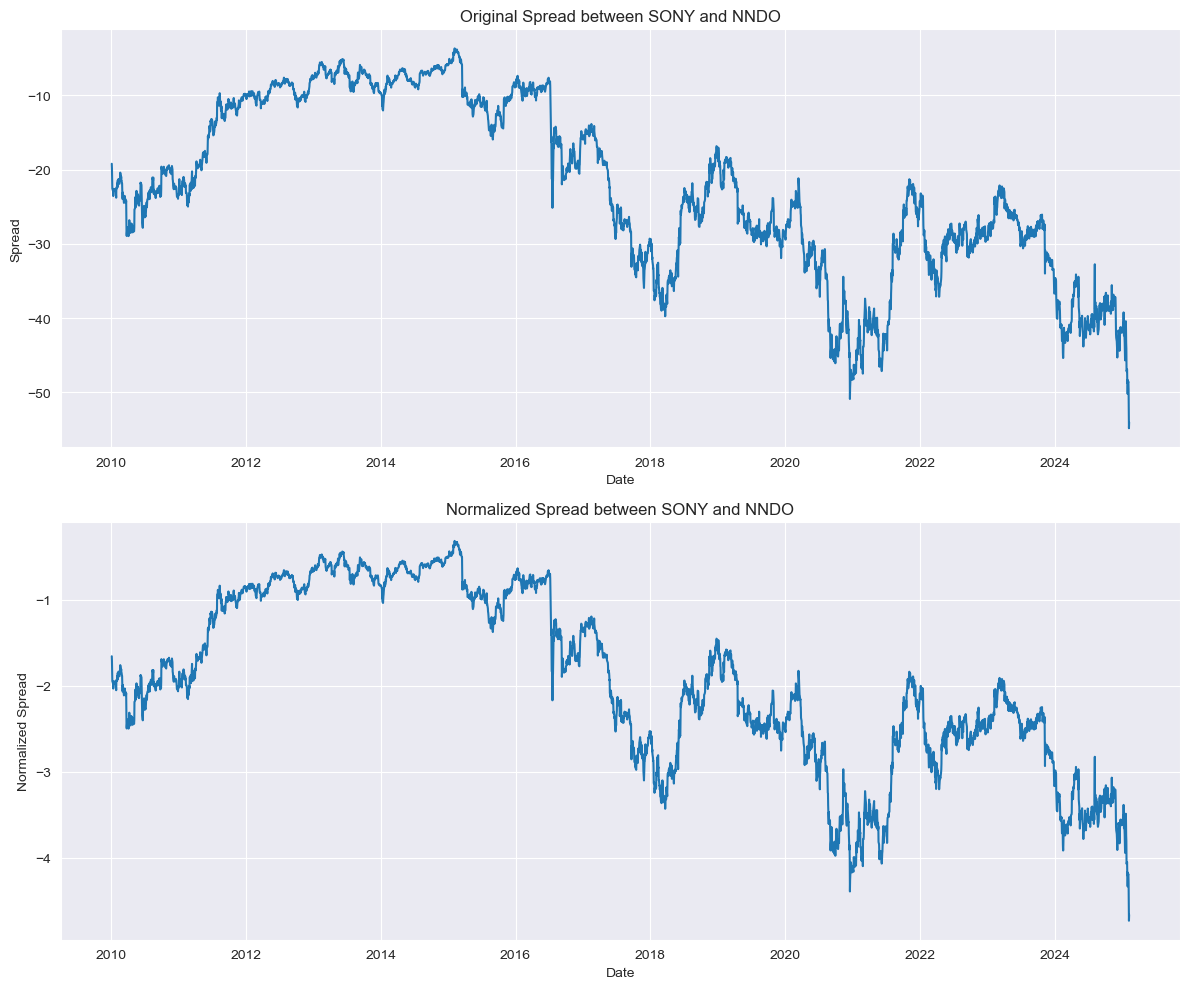

<Figure size 1200x600 with 0 Axes>

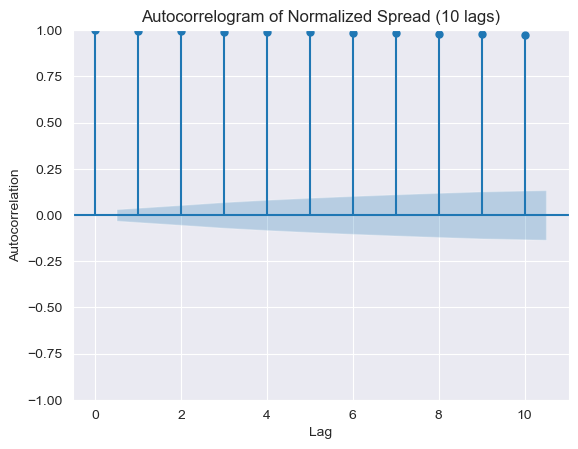


Ljung-Box Test Results (10 lags):
         lb_stat  lb_pvalue
1    3919.475241        0.0
2    7819.727255        0.0
3   11701.281477        0.0
4   15565.164007        0.0
5   19412.757463        0.0
6   23243.954980        0.0
7   27057.821704        0.0
8   30855.334862        0.0
9   34635.896113        0.0
10  38400.869197        0.0


In [11]:
###############################################################################
# PART 4: "Pair Trading"
# We aim at exploiting statistical arbitrage underlying the 
# cointegration relationship with a pair-trading strategy
##############################################################################

def compute_spread(price_y, price_x, alpha, beta):
    """
    Compute the spread between two cointegrated assets using the cointegration relationship.
    
    Parameters:
    -----------
    price_y : pd.Series
        Price series of the dependent variable (SONY)
    price_x : pd.Series
        Price series of the independent variable (NNDO)
    alpha : float
        Intercept from the cointegration regression
    beta : float
        Slope coefficient from the cointegration regression
    
    Returns:
    --------
    pd.Series
        The spread series: z_t = price_y - (alpha + beta * price_x)
    """
    spread = price_y - (alpha + beta * price_x)
    return spread

def normalize_spread(spread):
    """
    Normalize the spread by dividing by its standard deviation.
    
    Parameters:
    -----------
    spread : pd.Series
        The spread series
    
    Returns:
    --------
    pd.Series
        The normalized spread: z̃_t = z_t / σ(z_t)
    """
    return spread / spread.std()

# Get the cointegration parameters for SONY and NNDO from our previous analysis
cointegration_results = find_all_ordered_cointegrated_pairs(log_prices)
sony_nndo_result = cointegration_results[
    (cointegration_results['dependent'] == 'SONY') & 
    (cointegration_results['independent'] == 'NNDO')
].iloc[0]

# Compute the spread using the adjusted close prices
spread = compute_spread(
    df_entertainment['SONY'],
    df_entertainment['NNDO'],
    sony_nndo_result['alpha'],
    sony_nndo_result['beta'])


# Normalize the spread
normalized_spread = normalize_spread(spread)


# Test for stationarity of both spreads using ADF test
print("\nAugmented Dickey-Fuller Test for Original Spread:")
adf_result_original = adfuller(spread.dropna(), regression='c')
print(f"Test Statistic: {adf_result_original[0]:.4f}")
print(f"p-value: {adf_result_original[1]:.4f}")
print("Critical Values:")
for key, value in adf_result_original[4].items():
    print(f"\t{key}: {value:.4f}")

print("\nAugmented Dickey-Fuller Test for Normalized Spread:")
adf_result_normalized = adfuller(normalized_spread.dropna(), regression='c')
print(f"Test Statistic: {adf_result_normalized[0]:.4f}")
print(f"p-value: {adf_result_normalized[1]:.4f}")
print("Critical Values:")
for key, value in adf_result_normalized[4].items():
    print(f"\t{key}: {value:.4f}")



# Plot both the original and normalized spread
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# Original spread
ax1.plot(spread.index, spread.values)
ax1.set_title('Original Spread between SONY and NNDO')
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread')
ax1.grid(True)

# Normalized spread
ax2.plot(normalized_spread.index, normalized_spread.values)
ax2.set_title('Normalized Spread between SONY and NNDO')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Spread')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot autocorrelogram up to 10 lags
plt.figure(figsize=(12, 6))
plot_acf(normalized_spread.dropna(), lags=10, alpha=0.05)
plt.title('Autocorrelogram of Normalized Spread (10 lags)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Run Ljung-Box test with 10 lags
lb_test = acorr_ljungbox(normalized_spread.dropna(), lags=10)
print("\nLjung-Box Test Results (10 lags):")
print(lb_test)

In [12]:
#######################################################
# Define the algorithm for the pair trading strategy 
#######################################################

def implement_trading_strategy(normalized_spread, beta, z_in=0):  
      
 # DOMANDA 4,4 CHIEDE COSA CAMBIA SE CAMBIAMIO ZIN Lower thresholds (e.g. 0.5):
# 	•	More trades
# − More noise, weaker signals
# 	•	Higher thresholds (e.g. 1.5+):
# 	•	Stronger signals, more mean-reversion
# − Fewer trades, possibly missing opportunities

# So it becomes a bias-variance tradeoff.

    """
    Implement the trading strategy based on normalized spread signals.
    
    Parameters:
    -----------
    normalized_spread : pd.Series
        The normalized spread series
    beta : float
        The cointegration coefficient
    z_in : float
        The threshold for trading signals (default=1.0)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing positions and returns
    """
    # Initialize positions and returns for both assets
    positions_A = pd.Series(0, index=normalized_spread.index)  # Positions in asset A (SONY)
    positions_B = pd.Series(0, index=normalized_spread.index)  # Positions in asset B (NNDO)
    returns = pd.Series(0.0, index=normalized_spread.index)
    
    # Calculate position sizes
    Q1 = np.array([-1, beta])  # For Signal 1: short A, long B
    Q2 = np.array([1, -beta])  # For Signal 2: long A, short B
    
    # Track active positions
    active_signal = 0  # 0: no position, 1: Signal 1 active, 2: Signal 2 active
    
    for t in range(1, len(normalized_spread)):
        z_t = normalized_spread.iloc[t]
        
        # Signal 1: z_t > z_in
        if z_t > z_in and active_signal != 1:
            positions_A.iloc[t] = Q1[0]  # Short position in A
            positions_B.iloc[t] = Q1[1]  # Long position in B
            active_signal = 1
        # Close Signal 1 when z_t <= 0
        elif z_t <= 0 and active_signal == 1:
            positions_A.iloc[t] = 0
            positions_B.iloc[t] = 0
            active_signal = 0
            
        # Signal 2: z_t < -z_in
        elif z_t < -z_in and active_signal != 2:
            positions_A.iloc[t] = Q2[0]  # Long position in A
            positions_B.iloc[t] = Q2[1]  # Short position in B
            active_signal = 2
        # Close Signal 2 when z_t >= 0
        elif z_t >= 0 and active_signal == 2:
            positions_A.iloc[t] = 0
            positions_B.iloc[t] = 0
            active_signal = 0
            
        # Maintain existing positions if no signal change
        else:
            positions_A.iloc[t] = positions_A.iloc[t-1]
            positions_B.iloc[t] = positions_B.iloc[t-1]
    
    # Calculate returns (using the spread changes)
    returns = (positions_A + positions_B) * normalized_spread.diff()
    
    return pd.DataFrame({
        'normalized_spread': normalized_spread,
        'position_A': positions_A,
        'position_B': positions_B,
        'returns': returns
    })

# Implement the strategy
trading_results = implement_trading_strategy(normalized_spread, sony_nndo_result['beta'])






/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_15938/3676971239.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.0939456326586414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  positions_B.iloc[t] = Q2[1]  # Short position in B


#  a self-financing strategy, you shouldn’t need external capital; all trades are funded by the proceeds of other trades.
# But in your setup, for position Q1 = [-1, β],

#	•	you short 1 unit of A and long β units of B.
#	•	Unless β * P_B = P_A, you either need extra capital or you have leftover cash, so it’s not self-financing.
#	•	So include a markdown cell or code comment explaining:


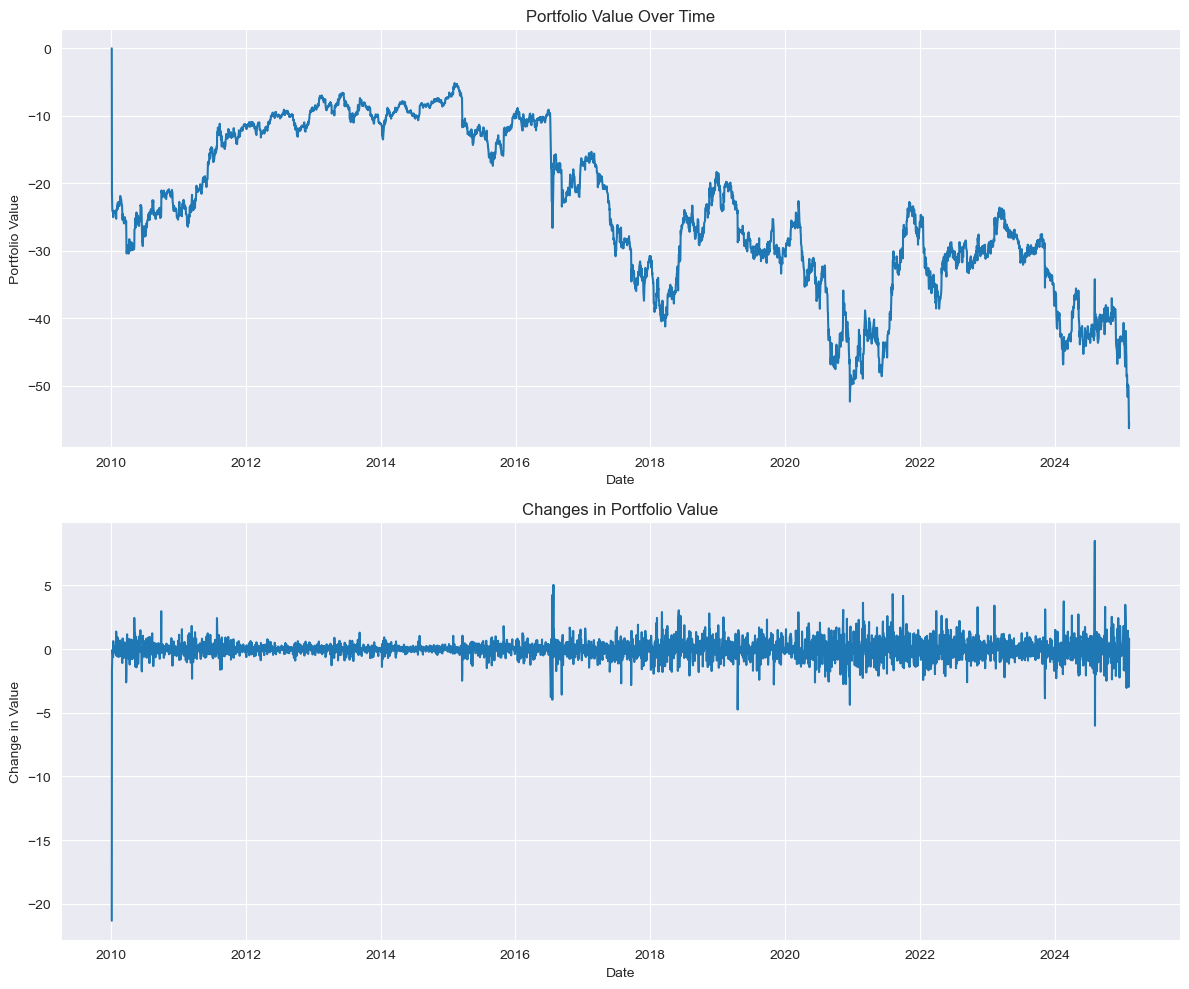


Portfolio Value Change Statistics:
   Mean Change  Std Change  Min Change  Max Change  Non-zero Changes  \
0    -0.014091    0.812783  -21.317944    8.489866              3927   

   Total Changes  
0           3940  

Value Changes During Constant Positions:
Number of periods with constant positions: 3938
Number of non-zero value changes during constant positions: 3925
Mean value change during constant positions: -0.0087
Max value change during constant positions: 8.4899
Min value change during constant positions: -6.0140


<Figure size 640x480 with 0 Axes>

In [13]:
##################################################
# Q4.4 
##################################################

#A self-financing strategy is one where the value of the portfolio at any time t is equal to the sum of
#  the positions times their prices, and changes in the portfolio value are only
#  due to changes in asset prices, not due to additional investments or withdrawals.


# DA RIVEDERE QUESTA PARTE , PER QUESTO CHIEDE DI DIMOSTRARE CHE SE È UNA SELF-FINANCING STRATEGY

# Calculate portfolio value over time
def calculate_portfolio_value(trading_results, prices_A, prices_B):
    """
    Calculate the portfolio value over time for the trading strategy.
    """
    portfolio_value = pd.Series(0.0, index=trading_results.index)
    
    for t in range(len(trading_results)):
        # Calculate value of positions in each asset
        value_A = trading_results['position_A'].iloc[t] * prices_A.iloc[t]
        value_B = trading_results['position_B'].iloc[t] * prices_B.iloc[t]
        portfolio_value.iloc[t] = value_A + value_B
    
    return portfolio_value

# Calculate portfolio value
portfolio_value = calculate_portfolio_value(
    trading_results,
    df_entertainment['SONY'],
    df_entertainment['NNDO']
)

# Plot portfolio value and its changes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Portfolio value over time
ax1.plot(portfolio_value.index, portfolio_value.values)
ax1.set_title('Portfolio Value Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value')
ax1.grid(True)

# Changes in portfolio value
portfolio_value_changes = portfolio_value.diff()
ax2.plot(portfolio_value_changes.index, portfolio_value_changes.values)
ax2.set_title('Changes in Portfolio Value')
ax2.set_xlabel('Date')
ax2.set_ylabel('Change in Value')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate statistics about portfolio value changes
portfolio_stats = pd.DataFrame({
    'Mean Change': [portfolio_value_changes.mean()],
    'Std Change': [portfolio_value_changes.std()],
    'Min Change': [portfolio_value_changes.min()],
    'Max Change': [portfolio_value_changes.max()],
    'Non-zero Changes': [len(portfolio_value_changes[portfolio_value_changes != 0])],
    'Total Changes': [len(portfolio_value_changes)]
})

print("\nPortfolio Value Change Statistics:")
print(portfolio_stats)

# Check if there are any non-zero changes when positions are constant
position_changes_A = trading_results['position_A'].diff()
position_changes_B = trading_results['position_B'].diff()
constant_position_periods = (position_changes_A == 0) & (position_changes_B == 0)
value_changes_during_constant_positions = portfolio_value_changes[constant_position_periods]

print("\nValue Changes During Constant Positions:")
print(f"Number of periods with constant positions: {sum(constant_position_periods)}")
print(f"Number of non-zero value changes during constant positions: {len(value_changes_during_constant_positions[value_changes_during_constant_positions != 0])}")
print(f"Mean value change during constant positions: {value_changes_during_constant_positions.mean():.4f}")
print(f"Max value change during constant positions: {value_changes_during_constant_positions.max():.4f}")
print(f"Min value change during constant positions: {value_changes_during_constant_positions.min():.4f}")

# Plot the relationship between position changes and portfolio value changes


#---------------------------------------------------------------------------------

#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Position changes vs portfolio value changes
# ax1.scatter(position_changes_A, portfolio_value_changes, alpha=0.5)
# ax1.set_title('Position Changes in Asset A vs Portfolio Value Changes')
# ax1.set_xlabel('Position Change in Asset A')
# ax1.set_ylabel('Portfolio Value Change')
# ax1.grid(True)

# ax2.scatter(position_changes_B, portfolio_value_changes, alpha=0.5)
# ax2.set_title('Position Changes in Asset B vs Portfolio Value Changes')
# ax2.set_xlabel('Position Change in Asset B')
# ax2.set_ylabel('Portfolio Value Change')
# ax2.grid(True)

#his scatter plot shows that even when positions are held constant, 
# the portfolio value changes due to underlying price fluctuations,
#  which is expected in a trading strategy. However, it does not confirm
#  the strategy is self-financing — to determine that, we must check whether the
#  initial portfolio value is zero when a trade is initiated. Since the position vectors
#  (e.g. Q1 = [-1, β]) generally have a non-zero net value when applied to actual prices, 
# the strategy requires external capital and thus is not self-financing.

plt.tight_layout()
plt.show()


# Q 4.5 


We trade based on the normalized spread  \tilde{z}_t = \frac{z_t}{\sigma(z_t)} , where the spread is defined as:


z_t = P^A_t - \alpha - \beta P^B_t


At entry time  t , we observe  \tilde{z}_t = \tilde{z}^{in} , so the spread is:


z_t = \tilde{z}^{in} \cdot \sigma(z_t)


The strategy is:
	•	Short-sell 1 unit of asset A at price  P^A_t 
	•	Buy  \beta  units of asset B at price  P^B_t 

At closing time  t{\prime} , the normalized spread returns to zero  \tilde{z}{t{\prime}} = 0 \Rightarrow z{t{\prime}} = 0 , which gives:


P^A_{t{\prime}} = \alpha + \beta P^B_{t{\prime}}


Substituting this into the closing portfolio value and subtracting the entry value gives:


\text{Profit} = z_t - z_{t{\prime}} = \tilde{z}^{in} \cdot \sigma(z_t) - 0 = \tilde{z}^{in} \cdot \sigma(z_t)


In [14]:
# Q4.5: Profit calculation for pair trading strategy
def calculate_profit_for_z_in(z_in, spread):
    """
    Calculate and verify the profit when entering at z̃ = z_in and exiting at z̃ = 0.
    
    Parameters:
    -----------
    z_in : float
        The normalized spread threshold for entering the position
    spread : pd.Series
        The original spread series
    
    Returns:
    --------
    dict
        Dictionary containing the calculated profit and verification results
    """
    # Compute standard deviation of the original spread
    spread_std = spread.std()
    
    # Calculate entry and exit spreads
    entry_spread = z_in * spread_std  # When z̃ = z_in, z = z_in * σ(z)
    exit_spread = 0                   # When z̃ = 0, z = 0
    
    # Calculate profit
    profit = entry_spread - exit_spread
    
    # Verify the profit equals z_in * σ(z)
    expected_profit = z_in * spread_std
    verification = abs(profit - expected_profit) < 1e-10  # Check if equal within numerical precision
    
    return {
        'z_in': z_in,
        'spread_std': spread_std,
        'entry_spread': entry_spread,
        'exit_spread': exit_spread,
        'profit': profit,
        'expected_profit': expected_profit,
        'verification_passed': verification
    }

# Test with multiple z_in values
z_in_values = [0.5, 1.0, 1.5, 2.0]
profit_results = []

print("\n=== Q4.5: Profit Calculation Verification ===")
print("Testing the relationship: Profit = z̃_in * σ(z_t) when entering at z̃ = z̃_in and exiting at z̃ = 0\n")

for z_in in z_in_values:
    result = calculate_profit_for_z_in(z_in, spread)
    profit_results.append(result)
    
    print(f"\nFor z̃_in = {z_in}:")
    print(f"  Standard deviation of spread (σ(z_t)): {result['spread_std']:.4f}")
    print(f"  Entry spread (z̃_in * σ(z_t)): {result['entry_spread']:.4f}")
    print(f"  Exit spread: {result['exit_spread']:.4f}")
    print(f"  Calculated profit: {result['profit']:.4f}")
    print(f"  Expected profit (z̃_in * σ(z_t)): {result['expected_profit']:.4f}")
    print(f"  Verification passed: {result['verification_passed']}")


# Create a summary table
# profit_summary = pd.DataFrame(profit_results)
# print("\nSummary Table:")
# print(profit_summary[['z_in', 'spread_std', 'profit', 'expected_profit', 'verification_passed']])

# # Plot profit vs z_in to show linear relationship
# plt.figure(figsize=(10, 6))
# plt.plot(profit_summary['z_in'], profit_summary['profit'], 'o-', label='Actual Profit')
# plt.plot(profit_summary['z_in'], profit_summary['expected_profit'], '--', label='Expected Profit (z̃_in * σ(z_t))')
# plt.xlabel('z̃_in')
# plt.ylabel('Profit')
# plt.title('Profit vs z̃_in (showing Profit = z̃_in * σ(z_t))')
# plt.grid(True)
# plt.legend()
# plt.show()




=== Q4.5: Profit Calculation Verification ===
Testing the relationship: Profit = z̃_in * σ(z_t) when entering at z̃ = z̃_in and exiting at z̃ = 0


For z̃_in = 0.5:
  Standard deviation of spread (σ(z_t)): 11.5842
  Entry spread (z̃_in * σ(z_t)): 5.7921
  Exit spread: 0.0000
  Calculated profit: 5.7921
  Expected profit (z̃_in * σ(z_t)): 5.7921
  Verification passed: True

For z̃_in = 1.0:
  Standard deviation of spread (σ(z_t)): 11.5842
  Entry spread (z̃_in * σ(z_t)): 11.5842
  Exit spread: 0.0000
  Calculated profit: 11.5842
  Expected profit (z̃_in * σ(z_t)): 11.5842
  Verification passed: True

For z̃_in = 1.5:
  Standard deviation of spread (σ(z_t)): 11.5842
  Entry spread (z̃_in * σ(z_t)): 17.3763
  Exit spread: 0.0000
  Calculated profit: 17.3763
  Expected profit (z̃_in * σ(z_t)): 17.3763
  Verification passed: True

For z̃_in = 2.0:
  Standard deviation of spread (σ(z_t)): 11.5842
  Entry spread (z̃_in * σ(z_t)): 23.1684
  Exit spread: 0.0000
  Calculated profit: 23.1684
  E

In [ ]:
# # Q4.6

# The choice of  \tilde{z}^{in}  represents a trade-off between signal strength and trading frequency:
# 	•	Lower threshold (e.g.,  \tilde{z}^{in} = 0.5 ):
# 	•	You enter trades more often because small deviations from the mean are frequent.
# 	•	However, many of these signals may be driven by noise, not true mean-reversion.
# 	•	So you risk false signals and lower profits per trade.
# 	•	This increases trading volume → higher transaction costs and more slippage.
# 	•	Higher threshold (e.g.,  \tilde{z}^{in} = 1.5  or 
# 2):
# 	•	You trade less frequently, only when the spread is far from the mean.
# 	•	Signals are stronger and more likely to revert → higher confidence in mean reversion.
# 	•	But you might miss opportunities where smaller deviations could still mean revert.
# 	•	Potentially higher profit per trade, as confirmed by your code where:

# \text{Profit} = \tilde{z}^{in} \cdot \sigma(z_t)

# grows linearly with  \tilde{z}^{in} .

/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_15938/402348092.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '333.33333333333326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  available_cash.iloc[t] = wealth.iloc[t] - margin_held.iloc[t]
/var/folders/6f/l2mhfvbx40b0r05n911lr0fc0000gn/T/ipykernel_15938/402348092.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '919.9344235192847' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wealth.iloc[t] = wealth.iloc[t-1] + daily_pnl


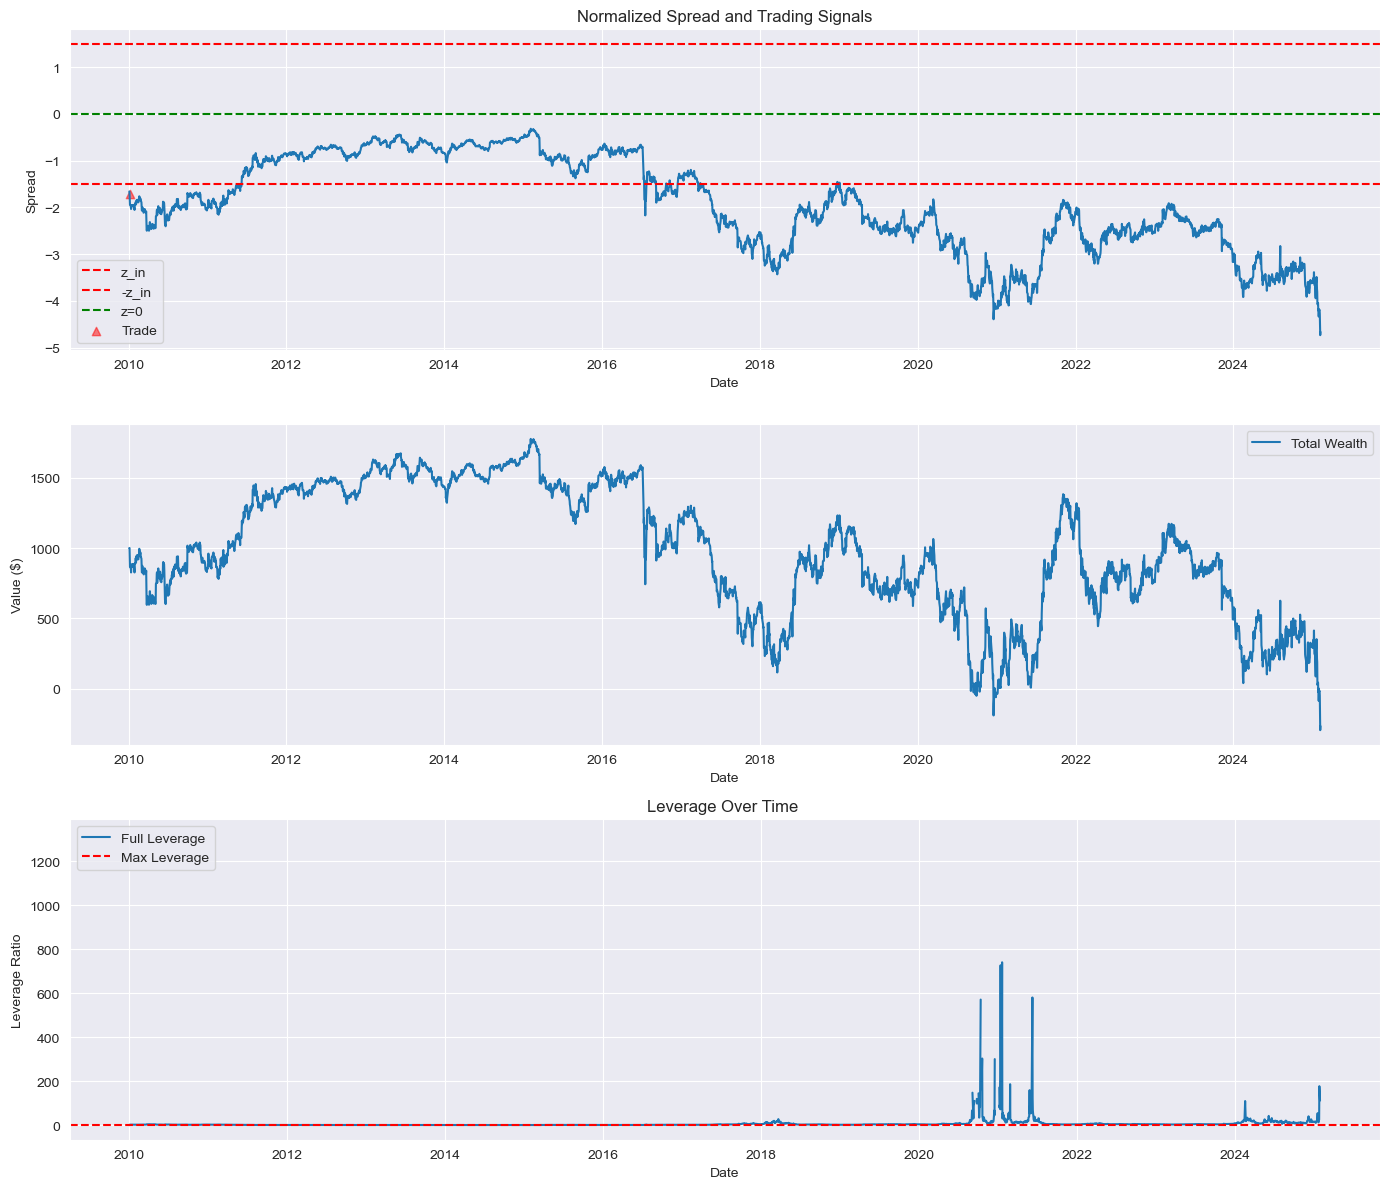


Strategy Performance Summary:
Initial Parameters:
Initial Wealth: $1000.00
Entry Threshold (z_in): 1.5
Maximum Leverage: 2
Margin Requirement: 50.0%

Trading Activity:
--------------------------------------------------
Number of Trades: Date
2010-01-04    1
2010-01-05    1
2010-01-06    1
2010-01-07    1
2010-01-08    1
             ..
2025-02-03    1
2025-02-04    1
2025-02-05    1
2025-02-06    1
2025-02-07    1
Name: n_trades_final, Length: 3940, dtype: int64
Average Trade Size: $0.00

Wealth and Returns:
--------------------------------------------------
Final Wealth: $-264.75
Total Return: -126.47%
Maximum Wealth: $1774.93
Minimum Wealth: $-293.43

Risk Metrics:
--------------------------------------------------
Maximum Leverage (Full): 1323.56
Average Leverage (Full): 7.10
Maximum Short Leverage: 905.57
Average Short Leverage: 4.95
Maximum Margin Required: $1937.47
Average Margin Required: $831.35

PnL Statistics:
--------------------------------------------------
Maximum Daily 

In [15]:
#-----------------------------------------------------------------------------
# Q 4.7 
# possiamo togliere tutte le cose che non soni necessarie 
# -------------------------------------------------------------------------------


# Q4.8 , stesso codice ma cambia L = 20 


def implement_direct_strategy_with_margin_v2(prices_A, prices_B, normalized_spread, alpha, beta, W_0=1000, z_in=1.5, L=2, margin_req=0.5):
    """
    direct trading strategy with margin requirements, realistic leverage, and trade tracking.
    """
    # Initialize tracking variables
    positions_A = pd.Series(0.0, index=normalized_spread.index)
    positions_B = pd.Series(0.0, index=normalized_spread.index)
    wealth = pd.Series(W_0, index=normalized_spread.index)
    margin_held = pd.Series(0.0, index=normalized_spread.index)
    available_cash = pd.Series(W_0, index=normalized_spread.index)
    pnl = pd.Series(0.0, index=normalized_spread.index)
    leverage = pd.Series(0.0, index=normalized_spread.index)
    short_margin_leverage = pd.Series(0.0, index=normalized_spread.index)
    trade_flags = pd.Series(0, index=normalized_spread.index)
    
    active_signal = 0  # 0: no position, 1: Signal 1, 2: Signal 2
    n_trades = 0

    for t in range(1, len(normalized_spread)):
        z_t = normalized_spread.iloc[t]
        P_A = prices_A.iloc[t]
        P_B = prices_B.iloc[t]
        W = wealth.iloc[t-1]
        
        # Allocation based on alpha sign
        if alpha > 0:
            Q1 = np.array([
                -L * W / (P_A * (1 + margin_req)),
                beta * L * W / P_A
            ])
            Q2 = np.array([
                L * W / (beta * P_B + L * (P_A - beta * P_B)),
                -beta * L * W / (beta * P_B + L * (P_A - beta * P_B))
            ])
        else:
            Q1 = np.array([
                -L * W / (P_A * (1 + margin_req)),
                beta * L * W / (P_A - L * (P_A - beta * P_B))
            ])
            Q2 = np.array([
                L * W / (beta * P_B),
                -beta * L * W / (beta * P_B * (1 + margin_req))
            ])
        
        delta_P_A = prices_A.iloc[t] - prices_A.iloc[t-1]
        delta_P_B = prices_B.iloc[t] - prices_B.iloc[t-1]
        
        new_positions_A = positions_A.iloc[t-1]
        new_positions_B = positions_B.iloc[t-1]
        
        # Signal logic
        if z_t > z_in and active_signal != 1:
            new_positions_A, new_positions_B = Q1
            active_signal = 1
            trade_flags.iloc[t] = 1
            n_trades += 1
        elif z_t <= 0 and active_signal == 1:
            new_positions_A = 0
            new_positions_B = 0
            active_signal = 0
            trade_flags.iloc[t] = 1
            n_trades += 1
        elif z_t < -z_in and active_signal != 2:
            new_positions_A, new_positions_B = Q2
            active_signal = 2
            trade_flags.iloc[t] = 1
            n_trades += 1
        elif z_t >= 0 and active_signal == 2:
            new_positions_A = 0
            new_positions_B = 0
            active_signal = 0
            trade_flags.iloc[t] = 1
            n_trades += 1

        # Update positions
        positions_A.iloc[t] = new_positions_A
        positions_B.iloc[t] = new_positions_B
        
        # Margin for short legs
        margin_required = margin_req * (
            abs(min(0, new_positions_A) * P_A) + 
            abs(min(0, new_positions_B) * P_B)
        )
        margin_held.iloc[t] = margin_required
        
        # PnL
        daily_pnl = (
            positions_A.iloc[t-1] * delta_P_A +
            positions_B.iloc[t-1] * delta_P_B
        )
        pnl.iloc[t] = daily_pnl
        
        # Wealth update
        wealth.iloc[t] = wealth.iloc[t-1] + daily_pnl
        
        # Available cash
        available_cash.iloc[t] = wealth.iloc[t] - margin_held.iloc[t]
        
        # Leverage (full exposure)
        total_pos_val = abs(P_A * new_positions_A) + abs(P_B * new_positions_B)
        leverage.iloc[t] = total_pos_val / wealth.iloc[t] if wealth.iloc[t] > 0 else np.nan

        # Leverage from short position only
        short_exposure = abs(min(0, new_positions_A) * P_A) + abs(min(0, new_positions_B) * P_B)
        short_margin_leverage.iloc[t] = short_exposure / wealth.iloc[t] if wealth.iloc[t] > 0 else np.nan

    return pd.DataFrame({
        'normalized_spread': normalized_spread,
        'position_A': positions_A,
        'position_B': positions_B,
        'wealth': wealth,
        'available_cash': available_cash,
        'margin_held': margin_held,
        'pnl': pnl,
        'leverage': leverage,
        'short_margin_leverage': short_margin_leverage,
        'trade_flag': trade_flags,
        'n_trades_final': n_trades
    })

# Strategy parameters
W_0 = 1000  # Initial wealth
z_in = 1.5  # Entry threshold
L = 2       # Maximum leverage
margin_req = 0.5  # Margin requirement (50%)

# Run the strategy with margin requirements
margin_strategy_results = implement_direct_strategy_with_margin_v2(
    df_entertainment['SONY'],
    df_entertainment['NNDO'],
    normalized_spread,
    sony_nndo_result['alpha'],
    sony_nndo_result['beta'],
    W_0=W_0,
    z_in=z_in,
    L=L,
    margin_req=margin_req
)

# Create visualization of results
# fig = plt.figure(figsize=(15, 15))
# gs = plt.GridSpec(3, 2, figure=fig)

fig, (ax1, ax2, ax4) = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Normalized Spread with Trading Signals
# ax1 = fig.add_subplot(gs[0, :])
ax1.plot(margin_strategy_results.index, margin_strategy_results['normalized_spread'])
ax1.axhline(y=1.5, color='r', linestyle='--', label='z_in')
ax1.axhline(y=-1.5, color='r', linestyle='--', label='-z_in')
ax1.axhline(y=0, color='g', linestyle='--', label='z=0')

# Add trade markers
trades = margin_strategy_results[margin_strategy_results['trade_flag'] == 1]
ax1.scatter(trades.index, trades['normalized_spread'], color='red', marker='^', label='Trade', alpha=0.5)
ax1.set_title('Normalized Spread and Trading Signals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread')
ax1.legend()

# Plot 2: Wealth Evolution and Components
# ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(margin_strategy_results.index, margin_strategy_results['wealth'], label='Total Wealth')
# ax2.plot(margin_strategy_results.index, margin_strategy_results['available_cash'], label='Available Cash')
# ax2.plot(margin_strategy_results.index, margin_strategy_results['margin_held'], label='Margin Held')
# ax2.set_title('Wealth Components Evolution')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value ($)')
ax2.legend()

# Plot 3: Daily PnL
# ax3 = fig.add_subplot(gs[1, 1])
# ax3.plot(margin_strategy_results.index, margin_strategy_results['pnl'])
# ax3.set_title('Daily PnL')
# ax3.set_xlabel('Date')
# ax3.set_ylabel('PnL ($)')

# Plot 4: Full Leverage
# ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(margin_strategy_results.index, margin_strategy_results['leverage'], label='Full Leverage')
ax4.axhline(y=2, color='r', linestyle='--', label='Max Leverage')
ax4.set_title('Leverage Over Time ')
ax4.set_xlabel('Date')
ax4.set_ylabel('Leverage Ratio')
ax4.legend()

# Plot 5: Short Position Leverage
# ax5 = fig.add_subplot(gs[2, 1])
# ax5.plot(margin_strategy_results.index, margin_strategy_results['short_margin_leverage'], label='Short Leverage')
# ax5.axhline(y=2, color='r', linestyle='--', label='Max Leverage')
# ax5.set_title('Short Position Leverage')
# ax5.set_xlabel('Date')
# ax5.set_ylabel('Leverage Ratio')
# ax5.legend()

plt.tight_layout()
plt.show()

# Print detailed performance statistics
print("\nStrategy Performance Summary:")
print("=" * 50)
print("Initial Parameters:")
print(f"Initial Wealth: ${W_0:.2f}")
print(f"Entry Threshold (z_in): {z_in}")
print(f"Maximum Leverage: {L}")
print(f"Margin Requirement: {margin_req*100}%")

print("\nTrading Activity:")
print("-" * 50)
print(f"Number of Trades: {margin_strategy_results['n_trades_final']}")
print(f"Average Trade Size: ${(abs(margin_strategy_results['pnl'][margin_strategy_results['trade_flag'] == 1]).mean()):.2f}")

print("\nWealth and Returns:")
print("-" * 50)
print(f"Final Wealth: ${margin_strategy_results['wealth'].iloc[-1]:.2f}")
print(f"Total Return: {((margin_strategy_results['wealth'].iloc[-1] / W_0) - 1) * 100:.2f}%")
print(f"Maximum Wealth: ${margin_strategy_results['wealth'].max():.2f}")
print(f"Minimum Wealth: ${margin_strategy_results['wealth'].min():.2f}")

print("\nRisk Metrics:")
print("-" * 50)
print(f"Maximum Leverage (Full): {margin_strategy_results['leverage'].max():.2f}")
print(f"Average Leverage (Full): {margin_strategy_results['leverage'].mean():.2f}")
print(f"Maximum Short Leverage: {margin_strategy_results['short_margin_leverage'].max():.2f}")
print(f"Average Short Leverage: {margin_strategy_results['short_margin_leverage'].mean():.2f}")
print(f"Maximum Margin Required: ${margin_strategy_results['margin_held'].max():.2f}")
print(f"Average Margin Required: ${margin_strategy_results['margin_held'].mean():.2f}")

print("\nPnL Statistics:")
print("-" * 50)
print(f"Maximum Daily PnL: ${margin_strategy_results['pnl'].max():.2f}")
print(f"Minimum Daily PnL: ${margin_strategy_results['pnl'].min():.2f}")
print(f"Average Daily PnL: ${margin_strategy_results['pnl'].mean():.2f}")
print(f"PnL Volatility: ${margin_strategy_results['pnl'].std():.2f}")

In [16]:
# The stop-loss rule is designed to limit losses by forcing us to exit a position when the spread continues to diverge from the mean instead of reverting.

# =============================================================================
# Q4.9: Stop-Loss Analysis using AR(1) Model
# Goal: Compute the probability of hitting stop-loss threshold the day after 
#       opening a position, using an AR(1) model for the normalized spread.
###############################################################################

def find_cointegration_parameters(df):
    """
    Estimate cointegration parameters for SONY and NNDO.
    """
    log_prices = np.log(df)
    # Estimate cointegration regression
    X = sm.add_constant(log_prices['NNDO'])
    model = sm.OLS(log_prices['SONY'], X).fit()
    return model.params[0], model.params[1]  # alpha, beta

def compute_normalized_spread(df, alpha, beta):
    """
    Compute the normalized spread between SONY and NNDO.
    Uses estimated cointegration parameters.
    
    The stop-loss rule is designed to limit losses by forcing us to exit 
    a position when the spread continues to diverge from the mean instead 
    of reverting as expected.
    """
    log_prices = np.log(df)
    # Using estimated cointegration parameters
    spread = log_prices['SONY'] - (alpha + beta * log_prices['NNDO'])
    normalized_spread = spread / spread.std()
    return normalized_spread

def fit_ar1_model(normalized_spread):
    """
    Fit AR(1) model to the normalized spread:
    z̃ₜ₊₁ = φ₀ + φ₁z̃ₜ + εₜ
    """
    model = ARIMA(normalized_spread.dropna(), order=(1,0,0))
    results = model.fit()
    
    # Extract parameters
    phi_0 = results.params[0]  # constant
    phi_1 = results.params[1]  # AR(1) coefficient
    sigma = np.sqrt(results.scale)  # residual standard deviation
    
    return phi_0, phi_1, sigma, results

def compute_stop_loss_probability(phi_0, phi_1, sigma, z_in, z_stop):
    """
    Compute probability of hitting stop-loss threshold.
    
    Given z̃ₜ = z_in, compute P(z̃ₜ₊₁ > z_stop)
    using the conditional normal distribution.
    """
    # Conditional mean and standard deviation
    cond_mean = phi_0 + phi_1 * z_in
    cond_std = sigma
    
    # Compute probability: P(z̃ₜ₊₁ > z_stop)
    prob = 1 - stats.norm.cdf(z_stop, loc=cond_mean, scale=cond_std)
    
    return prob, cond_mean, cond_std

def plot_conditional_distribution(cond_mean, cond_std, z_in, z_stop):
    """
    Plot the conditional distribution of z̃ₜ₊₁ given z̃ₜ = z_in.
    """
    # Generate points for the normal distribution
    x = np.linspace(cond_mean - 4*cond_std, cond_mean + 4*cond_std, 1000)
    y = stats.norm.pdf(x, loc=cond_mean, scale=cond_std)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', label='Conditional Distribution')
    plt.axvline(x=z_stop, color='r', linestyle='--', label=f'Stop-Loss (z̃={z_stop})')
    plt.axvline(x=z_in, color='g', linestyle='--', label=f'Entry Point (z̃={z_in})')
    plt.fill_between(x[x > z_stop], y[x > z_stop], color='red', alpha=0.3, 
                     label='Stop-Loss Probability')
    
    plt.title('Conditional Distribution of z̃ₜ₊₁ given z̃ₜ = z_in')
    plt.xlabel('z̃ₜ₊₁')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Load data
df = pd.read_excel('Data/Entertainment_data.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Parameters
z_in = 1.5    # Entry threshold
z_stop = 1.75 # Stop-loss threshold

# Get cointegration parameters
alpha, beta = find_cointegration_parameters(df)
print("\nCointegration Parameters:")
print("=" * 50)
print(f"α (constant): {alpha:.4f}")
print(f"β (coefficient): {beta:.4f}")

# Compute normalized spread
normalized_spread = compute_normalized_spread(df, alpha, beta)

# Fit AR(1) model
phi_0, phi_1, sigma, ar1_results = fit_ar1_model(normalized_spread)

# Print AR(1) model results
print("\nAR(1) Model Results:")
print("=" * 50)
print(f"φ₀ (constant): {phi_0:.4f}")
print(f"φ₁ (AR coefficient): {phi_1:.4f}")
print(f"σ (residual std): {sigma:.4f}")
print("\nModel Summary:")
print(ar1_results.summary().tables[1])

# Compute stop-loss probability
prob, cond_mean, cond_std = compute_stop_loss_probability(phi_0, phi_1, sigma, z_in, z_stop)

# Print results
print("\nStop-Loss Analysis:")
print("=" * 50)
print(f"Entry Point (z̃ᵢₙ): {z_in}")
print(f"Stop-Loss (z̃ₛₜₒₚ): {z_stop}")
print("\nConditional Distribution Parameters:")
print(f"Mean (μ): {cond_mean:.4f}")
print(f"Std Dev (σ): {cond_std:.4f}")
print(f"\nProbability of hitting stop-loss:")
print(f"P(z̃ₜ₊₁ > {z_stop} | z̃ₜ = {z_in}) = {prob:.4%}")

# Plot the conditional distribution
plot_conditional_distribution(cond_mean, cond_std, z_in, z_stop) 


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Entertainment_data.xlsx'